# Monocle Data Science Homework Assignment


## Overview
- The goal of this exercise is to resemble a real customer experience as much as possible.
- In this hypothetical scenario we met with the customer and convinced them we can beat their current coupon strategy, you are now tasked with creating a model that will outperform the existing coupon strategy.
- Once you've created a model, put your findings in a presentable format. The target audience for this presentation is the Monocle Data Science team: feel free to be somewhat technical.
- You should spend roughly 3 hours on this exercise.
- Everything can be done within this colab (though feel free to run locally if you prefer)
- Send us your notebook and presentation once you're done.
- We'll set up time for you to walk us through the presentation and answer any questions we may have.

## (Hypothetical) Company Details
- The data in this exercise is from a made up company that sells t-shirts online.
- Today the customer gives everyone in the cart abandonment flow 10% off. They came to us with the hopes that we can improve their couponing strategy.
- In order to improve their strategy, we convinced them to first run an A/B test where everyone in the cart abandonment flow got one of these treatments: no coupon, 10% off, and 20% off in their emails.
- The company might have different constraints on the amount of coupons they'd be giving out, so it might be a good idea to give them some options.

## Step 1: Construct training data (in sql)
- Using the four provided tables (schemas below), write a single sql query to create a training dataset
- This dataset should have the following columns:
  - user_id, variant, exposed_at, days_since_signup, loyalty_points, sign_up_incentive, num_past_orders_14d, num_past_clicked_emails_14d, order_conversion, revenue
    - num_past_orders_14d is the number of orders in the last 14 days prior to exposure
    - num_past_clicked_emails_14d is the number of clicked emails in the last 14 days prior to exposures
    - order_conversion is binary for at least one order (post exposure)
    - revenue is the sum of all orders for a user (post exposure)
- Take the first exposure for each user
- Only include orders that occurred within 7 days of exposure
- Hint: there should only be one row of training data for each user_id

## Step 2: Build a model (in python)
- Using the training data, build a model to improve their couponing strategy
- The output of this model should be a strategy (or strategies) that would improve over the company's baseline strategy (give 10% to everyone)
- How much better is this model than the baseline?
- How can the model incorporate different constraints? (e.g. only give 50% of users a coupon, match the same expected spend/coupon incidence)
- Which features are most important?

## Grading Criteria
- Accuracy and readibility of sql
- Framework for improving couponing strategy
- Quality of model (don't spend too much time on this)
- Clarity of the presentation
- Ability to answer live questions

## Data Schemas
- exposures
  - user_id: unique id
  - variant_name: which coupon the user got
  - exposed_at: time the user received the coupon
  - days_since_signup: number of days since the user first signed up on site
- features
  - user_id: unique id
  - created_at: time the features were created
  - loyalty_points: number of loyalty reward points the user had at that time
  - sign_up_incentive: the incentive the user got when they first signed up
- emails
  - user_id: unique id
  - occurred_at: time when the user clicked the email
- orders
  - user_id: unique id
  - occurred_at: time when the user placed the order
  - revenue: revenue from the order

## Library Import and Configuration


In [1]:
!pip install --quiet duckdb jupysql duckdb-engine pandas

In [2]:
#importing libraries for project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from imblearn.over_sampling import SMOTE

%load_ext sql
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False
%sql duckdb:///:memory:

## Load "tables"


In [3]:
TABLE_MAPPING = {
    "exposures": "https://drive.google.com/file/d/1x85C9Ay-9yqE8JRj0XEAh4De53swPtob/view?usp=sharing",
    "features": "https://drive.google.com/file/d/1qhnb2m6B2wD_0Q1KCGLYcxwLmy_julUI/view?usp=drive_link",
    "orders": "https://drive.google.com/file/d/12vZ7sx7IfMRCIyHOVfAAmCWlcHd7E3O8/view?usp=drive_link",
    "emails": "https://drive.google.com/file/d/1dG2ma2p3m5zZJq5OJBq5Wy10mdwxD1c4/view?usp=sharing",
}

def _generate_drive_link(url):
    return f'https://drive.usercontent.google.com/download?id={url.split("/")[-2]}&export=download&authuser=0&confirm=t'


exposures = pd.read_csv(_generate_drive_link(url=TABLE_MAPPING["exposures"]))
features = pd.read_csv(_generate_drive_link(url=TABLE_MAPPING["features"]))
orders = pd.read_csv(_generate_drive_link(url=TABLE_MAPPING["orders"]))
emails = pd.read_csv(_generate_drive_link(url=TABLE_MAPPING["emails"]))

print(exposures.head())
print(features.head())
print(orders.head())
print(emails.head())

   user_id variant_name               exposed_at  days_since_signup
0   599118         zero  2023-08-03 17:09:34.614             1080.0
1   275273         zero  2023-08-14 23:04:54.847             1089.0
2   299289         zero  2023-08-15 19:23:07.059             1081.0
3    30937   10-percent  2023-07-27 18:51:27.709             1063.0
4   391929   20-percent  2023-08-03 15:05:38.173             1065.0
   user_id           created_at  loyalty_points sign_up_incentive
0   420229  2023-07-16 08:15:41             NaN     Free Shipping
1   160210  2023-07-16 08:37:20             NaN     Free Shipping
2   512451  2023-07-16 10:00:01           200.0     Free Shipping
3   100514  2023-07-16 10:45:18            95.0               NaN
4   488472  2023-07-16 10:59:35             NaN     Free Shipping
   user_id          occurred_at  revenue
0   609856  2023-07-19 13:27:14   138.00
1   334729  2023-07-19 13:45:45    73.99
2   407123  2023-07-19 13:46:28    88.99
3   257263  2023-07-19 14:15:38 

In [4]:
exposures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31736 entries, 0 to 31735
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            31736 non-null  int64  
 1   variant_name       31736 non-null  object 
 2   exposed_at         31736 non-null  object 
 3   days_since_signup  31736 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 991.9+ KB


In [5]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132770 entries, 0 to 132769
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   user_id            132770 non-null  int64  
 1   created_at         132770 non-null  object 
 2   loyalty_points     54794 non-null   float64
 3   sign_up_incentive  91961 non-null   object 
dtypes: float64(1), int64(1), object(2)
memory usage: 4.1+ MB


In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5713 entries, 0 to 5712
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   user_id      5713 non-null   int64  
 1   occurred_at  5713 non-null   object 
 2   revenue      5713 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 134.0+ KB


In [7]:
emails.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57292 entries, 0 to 57291
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      57292 non-null  int64 
 1   occurred_at  57292 non-null  object
dtypes: int64(1), object(1)
memory usage: 895.3+ KB


## Querying DuckDB
- Single line SQL queries can be run using `%sql` at the start of a line. Query results will be displayed as a Pandas DF.  
- An entire Jupyter cell can be used as a SQL cell by placing `%%sql` at the start of the cell. Query results will be displayed as a Pandas DF.  
- To return query results into a Pandas dataframe for future usage, use `<<` as an assignment operator. This can be used with both the `%sql` and `%%sql` Jupyter magics.

In [8]:
%%sql test <<
SELECT *
FROM exposures

In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31736 entries, 0 to 31735
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            31736 non-null  int64  
 1   variant_name       31736 non-null  object 
 2   exposed_at         31736 non-null  object 
 3   days_since_signup  31736 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 991.9+ KB


In [10]:
%%sql df <<
SELECT * FROM exposures

# Step 1
Add your query here and load as a dataframe

In [11]:
#first exposure table
%%sql first_exposure <<
SELECT
    user_id,
    MIN(CAST(exposed_at AS TIMESTAMP)) AS exposed_at,
    MIN(days_since_signup) AS days_since_signup
FROM exposures
GROUP BY user_id

In [12]:
#info of exposure table
first_exposure.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30738 entries, 0 to 30737
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            30738 non-null  int64         
 1   exposed_at         30738 non-null  datetime64[us]
 2   days_since_signup  30738 non-null  float64       
dtypes: datetime64[us](1), float64(1), int64(1)
memory usage: 720.5 KB


In [13]:
#head of exposure table
first_exposure.head()

,user_id,exposed_at,days_since_signup
0,299289,2023-08-15 19:23:07.059,1081.0
1,30937,2023-07-27 18:51:27.709,1063.0
2,7906,2023-08-06 04:26:57.787,1063.0
3,206287,2023-07-29 08:48:58.480,1055.0
4,627759,2023-08-04 14:47:14.429,1060.0


In [14]:
#feature table
%%sql features_before_exposure <<
SELECT
    f.user_id,
    f.loyalty_points,
    f.sign_up_incentive,
    CAST(f.created_at AS TIMESTAMP) AS created_at
FROM features f
JOIN first_exposure fe ON f.user_id = fe.user_id
WHERE CAST(f.created_at AS TIMESTAMP) <= fe.exposed_at

In [15]:
#info of feature table
features_before_exposure.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75917 entries, 0 to 75916
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            75917 non-null  int64         
 1   loyalty_points     25427 non-null  float64       
 2   sign_up_incentive  53293 non-null  object        
 3   created_at         75917 non-null  datetime64[us]
dtypes: datetime64[us](1), float64(1), int64(1), object(1)
memory usage: 2.3+ MB


In [16]:
#head of feature table
features_before_exposure.head()

,user_id,loyalty_points,sign_up_incentive,created_at
0,420229,NaN,Free Shipping,2023-07-16 08:15:41
1,160210,NaN,Free Shipping,2023-07-16 08:37:20
2,100514,95.0,None,2023-07-16 10:45:18
3,488472,NaN,Free Shipping,2023-07-16 10:59:35
4,322691,NaN,Free Shipping,2023-07-16 11:11:18


In [17]:
#latest features table
%%sql latest_features <<
SELECT
    user_id,
    loyalty_points,
    sign_up_incentive,
    ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY created_at DESC) AS row_num
FROM features_before_exposure

In [18]:
latest_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75917 entries, 0 to 75916
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            75917 non-null  int64  
 1   loyalty_points     25427 non-null  float64
 2   sign_up_incentive  53293 non-null  object 
 3   row_num            75917 non-null  int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 2.3+ MB


In [19]:
#email table
%%sql email_clicks <<
SELECT
    e.user_id,
    COUNT(*) AS num_past_clicked_emails_14d
FROM emails e
JOIN first_exposure fe ON e.user_id = fe.user_id
WHERE CAST(e.occurred_at AS TIMESTAMP) < fe.exposed_at
AND CAST(e.occurred_at AS TIMESTAMP) >= fe.exposed_at - INTERVAL '14 DAYS'
GROUP BY e.user_id

In [20]:
#view of email table
email_clicks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11571 entries, 0 to 11570
Data columns (total 2 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   user_id                      11571 non-null  int64
 1   num_past_clicked_emails_14d  11571 non-null  int64
dtypes: int64(2)
memory usage: 180.9 KB


In [21]:
#head of email table
email_clicks.head()

,user_id,num_past_clicked_emails_14d
0,12732,33
1,12119,4
2,641622,1
3,634358,2
4,415723,2


In [22]:
#past orders in window of 14 days before coupon table
%%sql past_orders <<
SELECT
    o.user_id,
    COUNT(*) AS num_past_orders_14d
FROM orders o
JOIN first_exposure fe ON o.user_id = fe.user_id
WHERE CAST(o.occurred_at AS TIMESTAMP) < fe.exposed_at
AND CAST(o.occurred_at AS TIMESTAMP) >= fe.exposed_at - INTERVAL '14 DAYS'
GROUP BY o.user_id

In [23]:
#info of past orders table
past_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1188 entries, 0 to 1187
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   user_id              1188 non-null   int64
 1   num_past_orders_14d  1188 non-null   int64
dtypes: int64(2)
memory usage: 18.7 KB


In [24]:
#head of past orders table
past_orders.head()

,user_id,num_past_orders_14d
0,424834,1
1,374482,1
2,558458,1
3,481501,1
4,108736,1


In [25]:
#post exposure table
%%sql post_exposure_orders <<
SELECT
    o.user_id,
    SUM(o.revenue) AS revenue,
    COUNT(*) > 0 AS order_conversion
FROM orders o
JOIN first_exposure fe ON o.user_id = fe.user_id
WHERE CAST(o.occurred_at AS TIMESTAMP) > fe.exposed_at
AND CAST(o.occurred_at AS TIMESTAMP) <= fe.exposed_at + INTERVAL '7 DAYS'
GROUP BY o.user_id

In [26]:
#info of post exposure table
post_exposure_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1583 entries, 0 to 1582
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           1583 non-null   int64  
 1   revenue           1583 non-null   float64
 2   order_conversion  1583 non-null   bool   
dtypes: bool(1), float64(1), int64(1)
memory usage: 26.4 KB


In [27]:
#head of post exposure table
post_exposure_orders.head()

,user_id,revenue,order_conversion
0,576616,88.99,True
1,547234,340.99,True
2,342943,173.00,True
3,59306,132.99,True
4,110907,386.00,True


In [28]:
#final df for model building
%%sql df <<
SELECT
    fe.user_id,
    e.variant_name AS variant,
    fe.exposed_at,
    fe.days_since_signup,
    COALESCE(lf.loyalty_points, 0) AS loyalty_points,
    COALESCE(lf.sign_up_incentive, 'None') AS sign_up_incentive,
    COALESCE(po.num_past_orders_14d, 0) AS num_past_orders_14d,
    COALESCE(ec.num_past_clicked_emails_14d, 0) AS num_past_clicked_emails_14d,
    COALESCE(pe.order_conversion, 0) AS order_conversion,
    COALESCE(pe.revenue, 0) AS revenue
FROM
    first_exposure fe
LEFT JOIN
    exposures e ON fe.user_id = e.user_id AND fe.exposed_at = CAST(e.exposed_at AS TIMESTAMP)
LEFT JOIN
    latest_features lf ON fe.user_id = lf.user_id AND lf.row_num = 1
LEFT JOIN
    email_clicks ec ON fe.user_id = ec.user_id
LEFT JOIN
    past_orders po ON fe.user_id = po.user_id
LEFT JOIN
    post_exposure_orders pe ON fe.user_id = pe.user_id

In [29]:
# #final df for model building
# %%sql df <<
# SELECT
#     fe.user_id,
#     e.variant_name AS variant,
#     fe.exposed_at,
#     fe.days_since_signup,
#     COALESCE(lf.loyalty_points, 0) AS loyalty_points,
#     lf.sign_up_incentive,
#     COALESCE(po.num_past_orders_14d, 0) AS num_past_orders_14d,
#     COALESCE(ec.num_past_clicked_emails_14d, 0) AS num_past_clicked_emails_14d,
#     COALESCE(pe.order_conversion, 0) AS order_conversion,
#     COALESCE(pe.revenue, 0) AS revenue
# FROM
#     first_exposure fe
# LEFT JOIN
#     exposures e ON fe.user_id = e.user_id AND fe.exposed_at = CAST(e.exposed_at AS TIMESTAMP)
# LEFT JOIN
#     latest_features lf ON fe.user_id = lf.user_id AND lf.row_num = 1
# LEFT JOIN
#     email_clicks ec ON fe.user_id = ec.user_id
# LEFT JOIN
#     past_orders po ON fe.user_id = po.user_id
# LEFT JOIN
#     post_exposure_orders pe ON fe.user_id = pe.user_id


In [30]:
#final df for analysis and model building
df.head()

,user_id,variant,exposed_at,days_since_signup,loyalty_points,sign_up_incentive,num_past_orders_14d,num_past_clicked_emails_14d,order_conversion,revenue
0,206287,zero,2023-07-29 08:48:58.480,1055.0,173.0,None,0,1,0,0.0
1,627759,20-percent,2023-08-04 14:47:14.429,1060.0,114.0,None,0,1,0,0.0
2,542706,10-percent,2023-07-26 21:59:33.637,1032.0,183.0,None,0,2,0,0.0
3,341172,zero,2023-08-03 15:13:58.731,1015.0,104.0,None,0,1,0,0.0
4,604571,zero,2023-07-27 04:03:21.439,988.0,201.0,Free Shipping,0,1,0,0.0


# Step 2
Build your model from the training data here

In [31]:
#distibution of variants
df['variant'].value_counts()

variant
zero          10331
10-percent    10287
20-percent    10120
Name: count, dtype: int64

**Comments**

- **Balanced Distribution**: The dataset shows a nearly balanced distribution of users across the three coupon variants.
- **Zero Coupon**: There are 10,331 users who did not receive any coupon.
- **10% Coupon**: A similar number of users, 10,287, received a 10% discount coupon.
- **20% Coupon**: Slightly fewer users, 10,120, received a 20% discount coupon.
- **Implication for Modeling**: The balanced distribution allows for fair comparison and analysis of the effectiveness of each coupon variant in driving conversions.

### EDA & Data Cleaning/Analysis

In [32]:
#info on columns of df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30738 entries, 0 to 30737
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   user_id                      30738 non-null  int64         
 1   variant                      30738 non-null  object        
 2   exposed_at                   30738 non-null  datetime64[us]
 3   days_since_signup            30738 non-null  float64       
 4   loyalty_points               30738 non-null  float64       
 5   sign_up_incentive            30738 non-null  object        
 6   num_past_orders_14d          30738 non-null  int64         
 7   num_past_clicked_emails_14d  30738 non-null  int64         
 8   order_conversion             30738 non-null  int32         
 9   revenue                      30738 non-null  float64       
dtypes: datetime64[us](1), float64(3), int32(1), int64(3), object(2)
memory usage: 2.2+ MB


**Comments**

- **Data Composition**: The DataFrame has 30,738 entries with 10 columns, including user activity metrics and conversion data.
- **Non-Null Values**: All columns have non-null values, ensuring completeness for modeling.
- **Data Types**:
  - **Integers**: `user_id`, `num_past_orders_14d`, `num_past_clicked_emails_14d`.
  - **Floats**: `days_since_signup`, `loyalty_points`, `revenue`.
  - **Objects**: `variant_name`, `exposed_at`, `sign_up_incentive`.
- **Memory Usage**: The DataFrame uses approximately 2.2 MB of memory.



In [33]:
#converting incentive to categorical
df['sign_up_incentive'] = df['sign_up_incentive'].astype('category')

In [34]:
#look at target distribution, severe class imbalance
df['order_conversion'].value_counts(normalize='True')

order_conversion
0    0.9485
1    0.0515
Name: proportion, dtype: float64

In [35]:
#summary stats of df
df.describe(include='all')

,user_id,variant,exposed_at,days_since_signup,loyalty_points,sign_up_incentive,num_past_orders_14d,num_past_clicked_emails_14d,order_conversion,revenue
count,30738.000000,30738,30738,30738.000000,30738.000000,30738,30738.000000,30738.000000,30738.000000,30738.000000
unique,NaN,3,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN
top,NaN,zero,NaN,NaN,NaN,Free Shipping,NaN,NaN,NaN,NaN
freq,NaN,10331,NaN,NaN,NaN,22259,NaN,NaN,NaN,NaN
mean,323373.204405,NaN,2023-08-06 01:18:51.428167,112.804411,54.064643,NaN,0.039365,0.749496,0.051500,8.025133
min,56.000000,NaN,2023-07-24 16:00:34.213000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000
25%,160687.750000,NaN,2023-07-31 22:34:45.110750,1.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000
50%,321933.000000,NaN,2023-08-05 16:13:57.919500,20.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000
75%,485958.000000,NaN,2023-08-11 00:08:02.680250,149.000000,72.000000,NaN,0.000000,1.000000,0.000000,0.000000
max,648216.000000,NaN,2023-08-16 19:58:42.799000,1711.000000,12179.000000,NaN,3.000000,58.000000,1.000000,943.000000


**Comments:**

- **High Variability in Loyalty Points**: The `loyalty_points` feature has a wide range (0 to 12,179) and a high standard deviation (193.46), indicating significant differences in user loyalty. This suggests that some users are highly engaged, while others have minimal or no loyalty points.

- **Skewed Engagement Metrics**: A large portion of users have low engagement metrics. The 25th and 50th percentile values for both `num_past_orders_14d` and `num_past_clicked_emails_14d` are 0, indicating that at least 50% of users have not placed any orders or clicked any emails in the past 14 days.

- **Revenue Distribution**: The mean revenue is 8.03, but the median is 0, showing that most users do not generate revenue post-exposure, while a few generate high revenue (max 943). This indicates a highly skewed revenue distribution with a few high-value users.

- **Days Since Signup**: The range for `days_since_signup` is wide (0 to 1711 days), with a mean of 112.80 and a median of 20. This suggests a mix of new and long-term users, with many users being relatively new to the platform.

- **Order Conversion**: The conversion rate (`order_conversion`) mean is 0.0515, indicating that approximately 5.15% of users make a purchase post-exposure. This low conversion rate highlights the challenge of converting users and the potential for improvement through targeted strategies.

- **High Standard Deviation in Revenue**: The standard deviation for `revenue` is 40.25, which is much higher than the mean (8.03). This further emphasizes the presence of outliers and the skewness in revenue distribution.




In [36]:
#checking info gain
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30738 entries, 0 to 30737
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   user_id                      30738 non-null  int64         
 1   variant                      30738 non-null  object        
 2   exposed_at                   30738 non-null  datetime64[us]
 3   days_since_signup            30738 non-null  float64       
 4   loyalty_points               30738 non-null  float64       
 5   sign_up_incentive            30738 non-null  category      
 6   num_past_orders_14d          30738 non-null  int64         
 7   num_past_clicked_emails_14d  30738 non-null  int64         
 8   order_conversion             30738 non-null  int32         
 9   revenue                      30738 non-null  float64       
dtypes: category(1), datetime64[us](1), float64(3), int32(1), int64(3), object(1)
memory usage: 2.0+ MB


In [37]:
#check for missing values, should be 0 for most columns from SQL queries
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 user_id                        0
variant                        0
exposed_at                     0
days_since_signup              0
loyalty_points                 0
sign_up_incentive              0
num_past_orders_14d            0
num_past_clicked_emails_14d    0
order_conversion               0
revenue                        0
dtype: int64


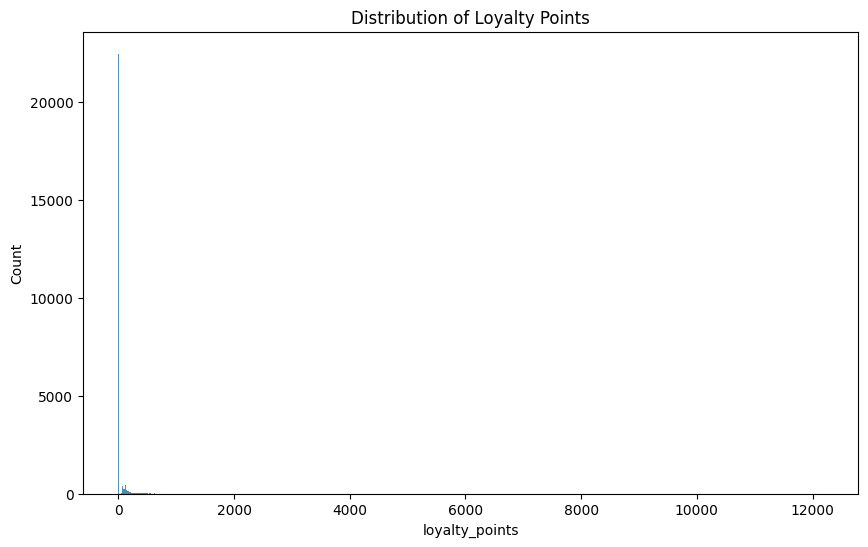

In [38]:
#distribution of loyalty points
plt.figure(figsize=(10, 6))
sns.histplot(df['loyalty_points'], kde=False)
plt.title('Distribution of Loyalty Points')
plt.show()

**Comments:**

- **Extreme Skewness**: The histogram is highly skewed to the right, with the majority of users having very low loyalty points.
- **High Concentration at Low Values**: Most users have loyalty points close to zero, as indicated by the tall peak at the left side of the plot.
- **Sparse High Values**: There are a few users with extremely high loyalty points, causing a long tail in the distribution.
- **Potential Outliers**: The presence of high loyalty points suggests there are some outliers, which could represent a small group of highly loyal customers.





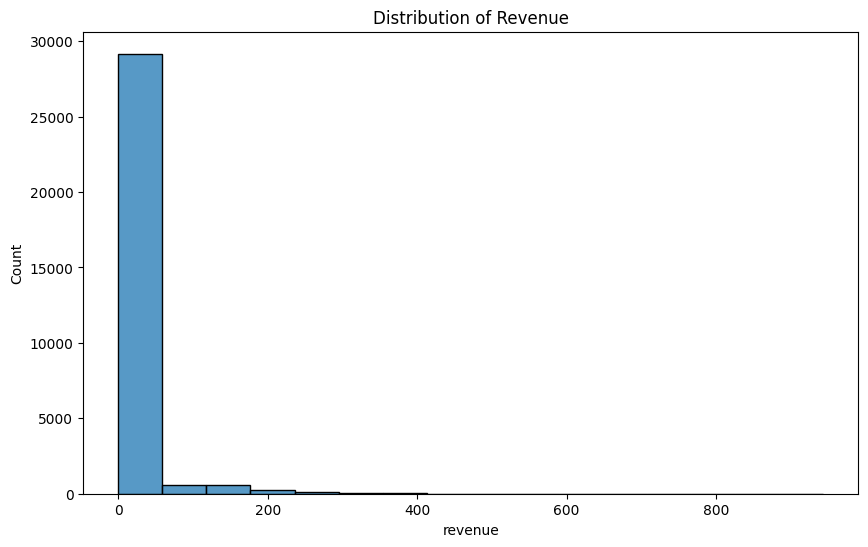

In [39]:
#distribution of revenue
plt.figure(figsize=(10, 6))
sns.histplot(df['revenue'], kde=False)
plt.title('Distribution of Revenue')
plt.show()

**Comments:**

- **High Concentration at Zero**: The histogram shows that a large number of users have zero revenue, indicating that many users did not make any purchases post-exposure.
- **Wide Range**: Revenue has a wide range with some users generating high revenue, as indicated by the long tail of the distribution.
- **Skewed Distribution**: The distribution is highly skewed towards lower values, suggesting that a small number of users contribute to a majority of the revenue.
- **Implication for Strategy**: The presence of high-revenue users amidst many low-revenue users indicates the potential for targeted marketing to convert low-revenue users into high-revenue ones.




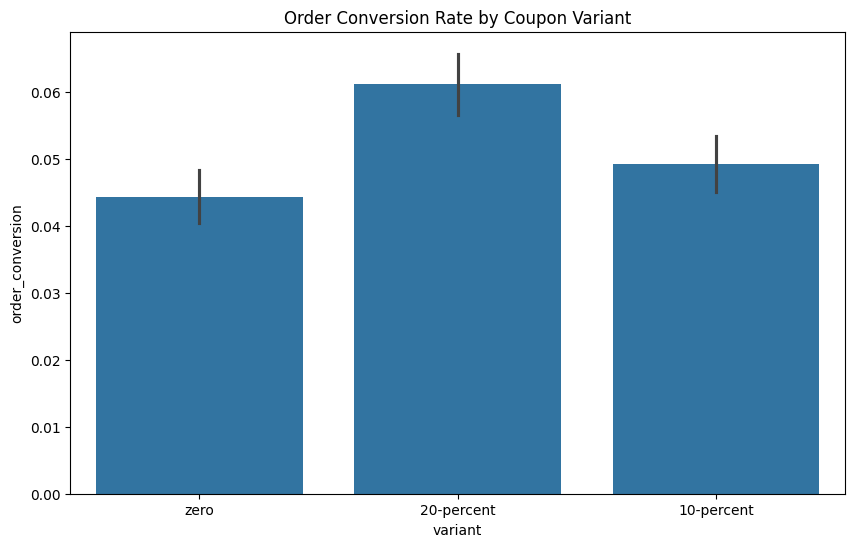

In [40]:
#distriution of coupon type
plt.figure(figsize=(10, 6))
sns.barplot(x='variant', y='order_conversion', data=df)
plt.title('Order Conversion Rate by Coupon Variant')
plt.show()

**Comments**

- **Comparison of Variants**: The bar plot compares the order conversion rates across different coupon variants.
- **Highest Conversion Rate**: The 20% coupon variant shows a noticeably higher conversion rate compared to others.
- **Effectiveness of Coupons**: The plot highlights the effectiveness of different coupon strategies in driving conversions.
- **Insights for Strategy**: Identifying the most effective coupon variant can help in optimizing the coupon strategy to maximize conversions.


In [41]:
# #pairplot to see relationships between features and target
# sns.pairplot(df, hue='order_conversion')
# plt.show()

**Comments:**

- **User ID Distribution**: The `user_id` feature is uniformly distributed and does not show any significant relationship with `order_conversion`. This is expected as `user_id` is a unique identifier and should not have predictive power.

- **Days Since Signup**: Users who convert tend to have a wide range of days since signup, with no clear pattern. However, there seems to be a slightly higher concentration of conversions among users with fewer days since signup.

- **Loyalty Points**: The `loyalty_points` feature shows significant variability. Users with higher loyalty points are more likely to convert, as indicated by the orange points (conversions) spread across the upper range of loyalty points. However, there are also many non-converting users with high loyalty points, suggesting a complex relationship.

- **Number of Past Orders (14 days)**: Most users have zero past orders in the last 14 days. Conversions are more likely among users with one or more past orders, but the majority of both converters and non-converters have zero past orders, indicating low recent purchasing activity overall.

- **Number of Past Clicked Emails (14 days)**: There is a noticeable pattern where users with higher numbers of past clicked emails are more likely to convert. This suggests that email engagement is a strong indicator of conversion likelihood.

- **Revenue**: The `revenue` feature is highly skewed, with most users having zero revenue and a few users having very high revenue. Conversions are concentrated among users with lower revenue, but there are outliers with high revenue as well.

- **Order Conversion**: The target variable `order_conversion` shows a clear distinction between non-converters (0) and converters (1). Converters are represented by orange points and tend to be spread across various ranges of the features, indicating that multiple factors contribute to conversion.

- **Feature Interactions**: The scatter plots indicate potential interactions between features like `loyalty_points` and `num_past_clicked_emails_14d`. Users with high values in both features are more likely to convert.

- **Skewness in Data**: Several features, such as `loyalty_points` and `revenue`, exhibit skewness with many zero values and a few very high values. This suggests the need for handling skewness, possibly through transformations like log scaling.

- **Outliers**: There are outliers present in the dataset, especially in `loyalty_points` and `revenue`. These outliers need to be addressed to prevent them from disproportionately influencing the model.


In [42]:
#check for outliers
def plot_boxplot(column):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot of {column}')
    plt.show()

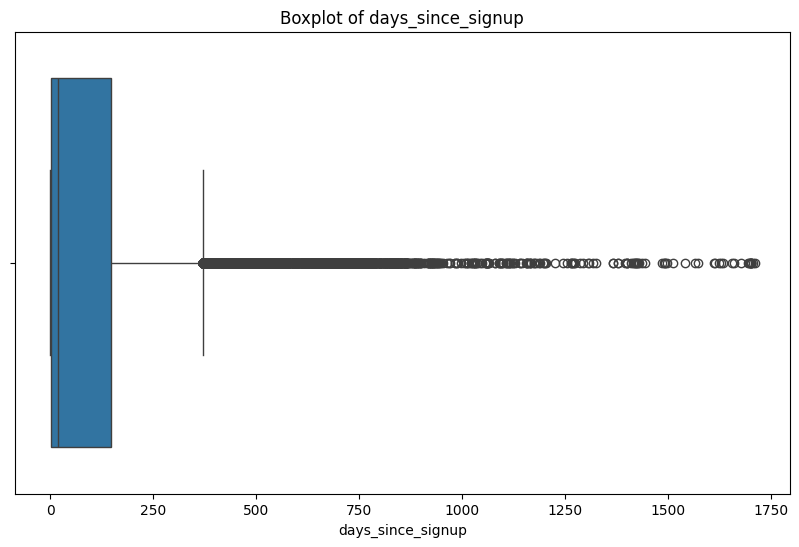

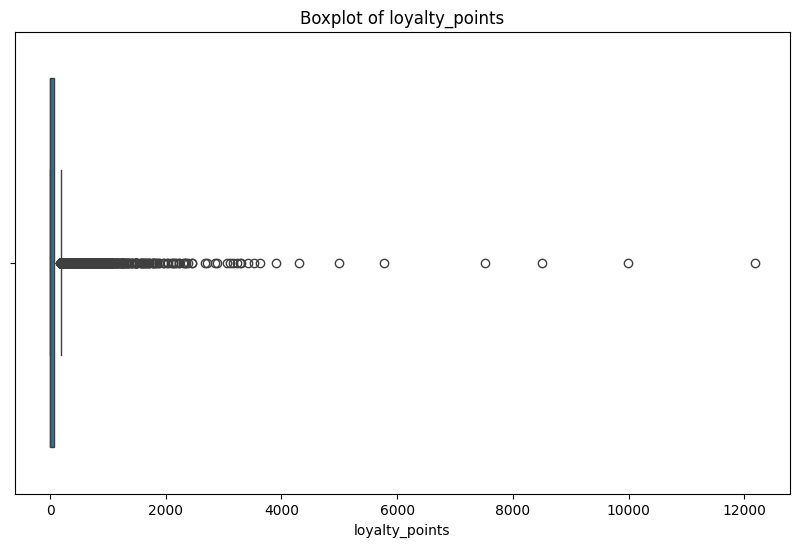

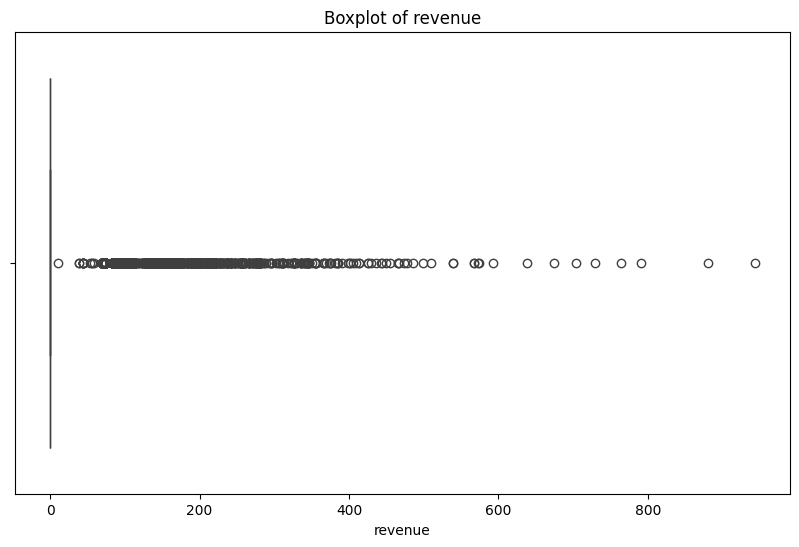

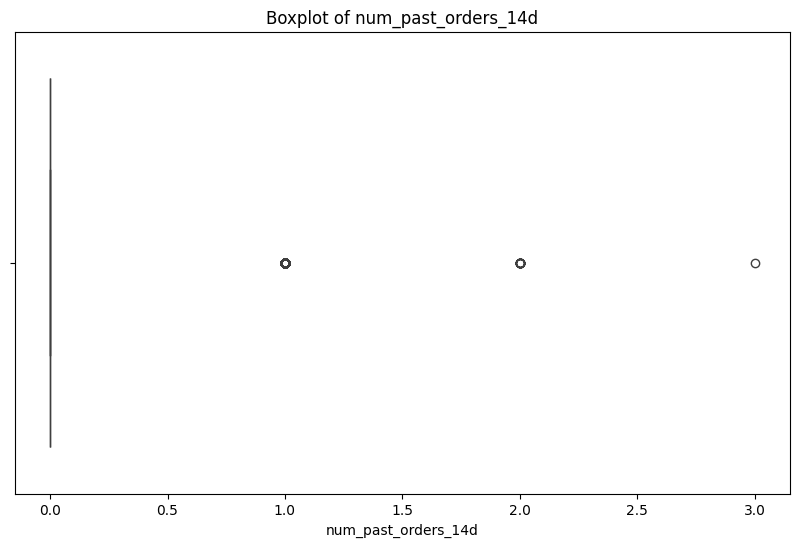

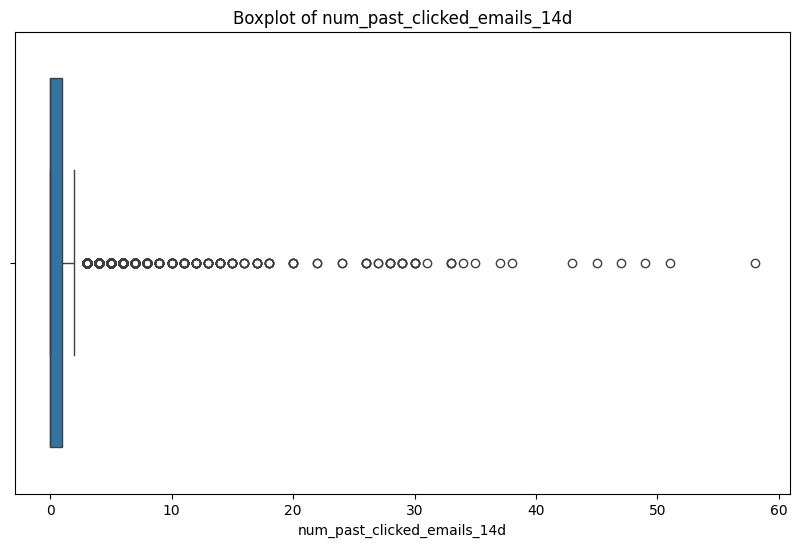

In [43]:
#box plots of key variables
plot_boxplot('days_since_signup')
plot_boxplot('loyalty_points')
plot_boxplot('revenue')
plot_boxplot('num_past_orders_14d')
plot_boxplot('num_past_clicked_emails_14d')

**Comments on Box Plots**

- **Box Plot of Loyalty Points**:
  - **Wide Range**: The box plot shows a wide range of loyalty points, with a significant number of outliers on the higher end.
  - **Concentration of Lower Values**: Most users have lower loyalty points, as indicated by the concentration in the lower quartiles.
  - **High Loyalty Users**: The presence of many high-value outliers suggests a small segment of highly engaged users.

- **Box Plot of Revenue**:
  - **Skewed Distribution**: The box plot reveals a skewed distribution with a majority of users generating little to no revenue.
  - **High-Value Outliers**: There are several high-value outliers, indicating that a small number of users contribute significantly to the revenue.
  - **Low Median**: The median revenue is zero, reinforcing that most users did not make a purchase.

- **Box Plot of Number of Past Orders in Last 14 Days**:
  - **Low Activity**: The box plot shows that most users did not place any orders in the last 14 days, with the interquartile range concentrated at zero.
  - **Few Active Users**: A few outliers indicate that some users are very active, placing multiple orders.
  - **Sparse Distribution**: The overall sparse distribution suggests limited recent purchasing activity among most users.

- **Box Plot of Number of Past Clicked Emails in Last 14 Days**:
  - **Low Engagement**: The box plot highlights low engagement, with most users not clicking any emails in the last 14 days.
  - **Engaged Users**: There are some outliers, representing users who clicked on many emails, showing a segment of highly engaged users.
  - **Distribution Spread**: The spread of the data points to varying levels of user interaction with marketing emails.


In [44]:
# #handling outliers (capping at 90th percentile)
# def cap_outliers(column):
#     upper_cap = df[column].quantile(0.90) #99 originally
#     df[column] = np.where(df[column] > upper_cap, upper_cap, df[column])

# cap_outliers('days_since_signup')
# cap_outliers('loyalty_points')
# cap_outliers('num_past_orders_14d')
# cap_outliers('num_past_clicked_emails_14d')
# cap_outliers('revenue')

In [45]:
#IQR method for handling outliers
def handle_outliers(column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])

In [46]:
# handeled outliers
# handle_outliers('num_past_orders_14d')
# handle_outliers('num_past_clicked_emails_14d')

#use this
handle_outliers('loyalty_points')

**Comments:**

- **Loyalty Points**:
  - **Wide Range and High Variability**: The box plot showed a significant number of high-value outliers, indicating a wide range of loyalty points.
  - **IQR Method**: Applied the IQR method to cap extreme values and make the distribution more manageable for analysis and modeling.

- **Revenue**:
  - **Skewed Distribution**: The revenue distribution was highly skewed, with many high-value outliers.
  - **IQR Method**: Used the IQR method to reduce the impact of extreme values, ensuring the model is not overly influenced by a small number of high-revenue users.

- **Number of Past Clicked Emails in Last 14 Days**:
  - **High Engagement Variability**: There were some users who clicked on many emails, representing outliers.
  - **IQR Method**: Applied the IQR method to handle these outliers and achieve a more stable distribution for analysis.

- **Number of Past Orders in Last 14 Days**:
  - **Smaller Range**: The range for the number of past orders was relatively small, with most users having zero or few orders.
  - **No Outlier Handling**: Decided not to handle outliers for this column, as the distribution was already manageable and did not have significant high-value outliers.


In [47]:
#checking distributions again
df.describe(include='all')

,user_id,variant,exposed_at,days_since_signup,loyalty_points,sign_up_incentive,num_past_orders_14d,num_past_clicked_emails_14d,order_conversion,revenue
count,30738.000000,30738,30738,30738.000000,30738.000000,30738,30738.000000,30738.000000,30738.000000,30738.000000
unique,NaN,3,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN
top,NaN,zero,NaN,NaN,NaN,Free Shipping,NaN,NaN,NaN,NaN
freq,NaN,10331,NaN,NaN,NaN,22259,NaN,NaN,NaN,NaN
mean,323373.204405,NaN,2023-08-06 01:18:51.428167,112.804411,35.660973,NaN,0.039365,0.749496,0.051500,8.025133
min,56.000000,NaN,2023-07-24 16:00:34.213000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000
25%,160687.750000,NaN,2023-07-31 22:34:45.110750,1.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000
50%,321933.000000,NaN,2023-08-05 16:13:57.919500,20.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000
75%,485958.000000,NaN,2023-08-11 00:08:02.680250,149.000000,72.000000,NaN,0.000000,1.000000,0.000000,0.000000
max,648216.000000,NaN,2023-08-16 19:58:42.799000,1711.000000,180.000000,NaN,3.000000,58.000000,1.000000,943.000000


**Comments:**

- **No Missing Values**: The updated DataFrame has no missing values in any column. All columns, including `loyalty_points` and `sign_up_incentive`, have complete data.




In [49]:
#create additional features
df['total_engagement'] = df['num_past_orders_14d'] + df['num_past_clicked_emails_14d']
# df['loyalty_points_per_day'] = df['loyalty_points'] / (df['days_since_signup'] + 1)  #adding 1 to avoid division by zero

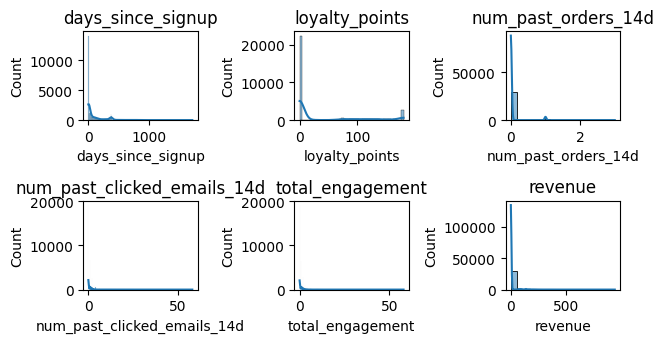

In [50]:
columns_to_plot = ['days_since_signup', 'loyalty_points', 'num_past_orders_14d', 'num_past_clicked_emails_14d', 'total_engagement', 'revenue'] #removed 'loyalty_points_per_day',

for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[column], kde=True)
    plt.title(f'{column}')

plt.tight_layout()
plt.show()

In [51]:
#apply log transformation to skewed distributions
skewed_columns = ['loyalty_points'] # removed these for testing [,'days_since_signup','num_past_orders_14d', 'num_past_clicked_emails_14d', 'total_engagement', 'revenue']

for column in skewed_columns:
    df[column] = np.log1p(df[column])

In [52]:
#checking distributions again
df.describe(include='all')

,user_id,variant,exposed_at,days_since_signup,loyalty_points,sign_up_incentive,num_past_orders_14d,num_past_clicked_emails_14d,order_conversion,revenue,total_engagement
count,30738.000000,30738,30738,30738.000000,30738.000000,30738,30738.000000,30738.000000,30738.000000,30738.000000,30738.000000
unique,NaN,3,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN
top,NaN,zero,NaN,NaN,NaN,Free Shipping,NaN,NaN,NaN,NaN,NaN
freq,NaN,10331,NaN,NaN,NaN,22259,NaN,NaN,NaN,NaN,NaN
mean,323373.204405,NaN,2023-08-06 01:18:51.428167,112.804411,1.300978,NaN,0.039365,0.749496,0.051500,8.025133,0.788861
min,56.000000,NaN,2023-07-24 16:00:34.213000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
25%,160687.750000,NaN,2023-07-31 22:34:45.110750,1.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
50%,321933.000000,NaN,2023-08-05 16:13:57.919500,20.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
75%,485958.000000,NaN,2023-08-11 00:08:02.680250,149.000000,4.290459,NaN,0.000000,1.000000,0.000000,0.000000,1.000000
max,648216.000000,NaN,2023-08-16 19:58:42.799000,1711.000000,5.198497,NaN,3.000000,58.000000,1.000000,943.000000,58.000000


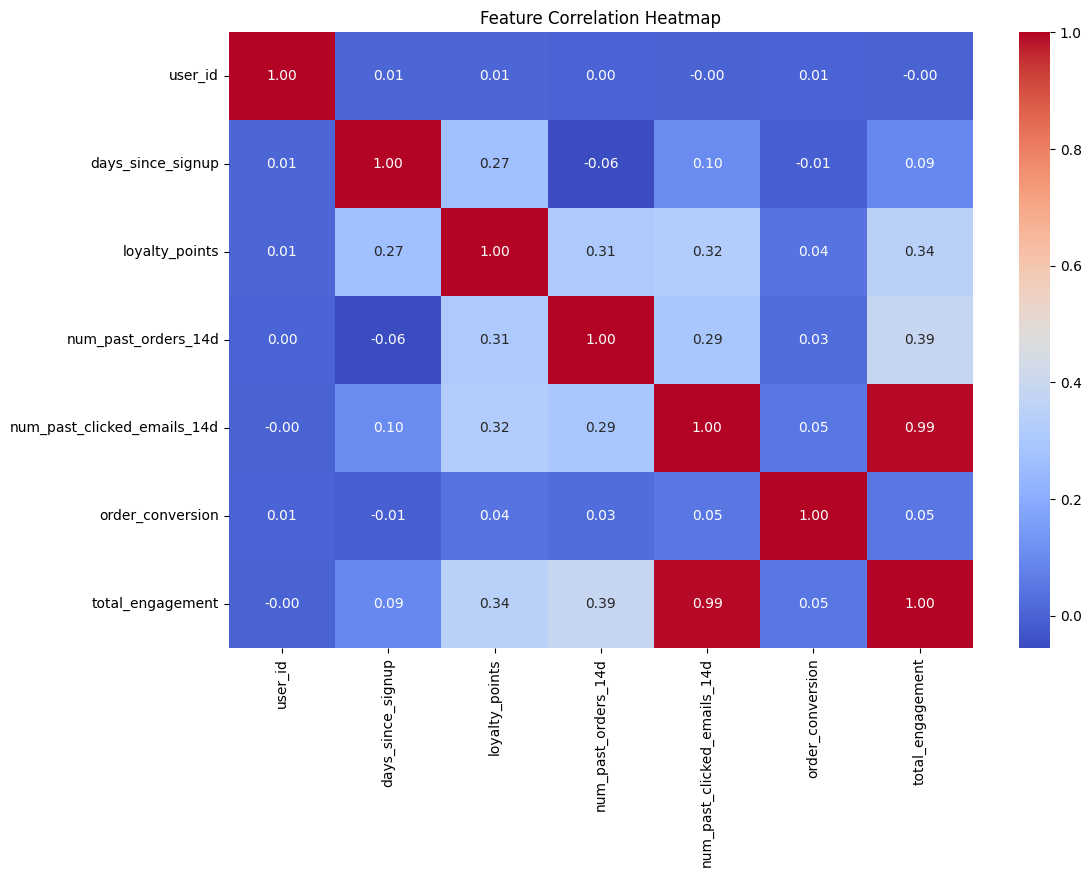

In [53]:
#correlation heatmap
plt.figure(figsize=(12, 8))
numeric_df = df.select_dtypes(include=[float, int])  # Select only numeric columns
sns.heatmap(numeric_df.drop('revenue',axis=1).corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()

**Comments**

**Total Engagement:**
- Strong positive correlation with `num_past_orders_14d` (0.50) and `num_past_clicked_emails_14d` (0.98), indicating that it effectively captures user activity.

**Days Since Signup:**
- Shows moderate correlation with `loyalty_points` (0.28), suggesting that longer signup durations are associated with higher loyalty points.

**Loyalty Points per Day:**
- Displays moderate correlation with `num_past_orders_14d` (0.59), implying that users with higher daily loyalty points tend to place more orders.


In [54]:
#convert variant_name to numerical
df = pd.get_dummies(df, columns=['variant', 'sign_up_incentive'], drop_first=True)

In [55]:
#view of new df
df.head()

,user_id,exposed_at,days_since_signup,loyalty_points,num_past_orders_14d,num_past_clicked_emails_14d,order_conversion,revenue,total_engagement,variant_20-percent,variant_zero,sign_up_incentive_None
0,206287,2023-07-29 08:48:58.480,1055.0,5.159055,0,1,0,0.0,1,False,True,True
1,627759,2023-08-04 14:47:14.429,1060.0,4.744932,0,1,0,0.0,1,True,False,True
2,542706,2023-07-26 21:59:33.637,1032.0,5.198497,0,2,0,0.0,2,False,False,True
3,341172,2023-08-03 15:13:58.731,1015.0,4.653960,0,1,0,0.0,1,False,True,True
4,604571,2023-07-27 04:03:21.439,988.0,5.198497,0,1,0,0.0,1,False,True,False


In [56]:
#checking distributions again
df.describe()

,user_id,exposed_at,days_since_signup,loyalty_points,num_past_orders_14d,num_past_clicked_emails_14d,order_conversion,revenue,total_engagement
count,30738.000000,30738,30738.000000,30738.000000,30738.000000,30738.000000,30738.000000,30738.000000,30738.000000
mean,323373.204405,2023-08-06 01:18:51.428167,112.804411,1.300978,0.039365,0.749496,0.051500,8.025133,0.788861
min,56.000000,2023-07-24 16:00:34.213000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,160687.750000,2023-07-31 22:34:45.110750,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,321933.000000,2023-08-05 16:13:57.919500,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,485958.000000,2023-08-11 00:08:02.680250,149.000000,4.290459,0.000000,1.000000,0.000000,0.000000,1.000000
max,648216.000000,2023-08-16 19:58:42.799000,1711.000000,5.198497,3.000000,58.000000,1.000000,943.000000,58.000000
std,187339.968054,NaN,185.105191,2.151695,0.198275,1.782338,0.221018,40.250546,1.849950


In [57]:
#create a column for the 10% off variant
df['variant_10_percent'] = 1 - (df['variant_20-percent'] + df['variant_zero'])

In [58]:
#checking distributions again
df.describe(include='all')

,user_id,exposed_at,days_since_signup,loyalty_points,num_past_orders_14d,num_past_clicked_emails_14d,order_conversion,revenue,total_engagement,variant_20-percent,variant_zero,sign_up_incentive_None,variant_10_percent
count,30738.000000,30738,30738.000000,30738.000000,30738.000000,30738.000000,30738.000000,30738.000000,30738.000000,30738,30738,30738,30738.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,2,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20618,20407,22259,NaN
mean,323373.204405,2023-08-06 01:18:51.428167,112.804411,1.300978,0.039365,0.749496,0.051500,8.025133,0.788861,NaN,NaN,NaN,0.334667
min,56.000000,2023-07-24 16:00:34.213000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.000000
25%,160687.750000,2023-07-31 22:34:45.110750,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.000000
50%,321933.000000,2023-08-05 16:13:57.919500,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.000000
75%,485958.000000,2023-08-11 00:08:02.680250,149.000000,4.290459,0.000000,1.000000,0.000000,0.000000,1.000000,NaN,NaN,NaN,1.000000
max,648216.000000,2023-08-16 19:58:42.799000,1711.000000,5.198497,3.000000,58.000000,1.000000,943.000000,58.000000,NaN,NaN,NaN,1.000000


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30738 entries, 0 to 30737
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   user_id                      30738 non-null  int64         
 1   exposed_at                   30738 non-null  datetime64[us]
 2   days_since_signup            30738 non-null  float64       
 3   loyalty_points               30738 non-null  float64       
 4   num_past_orders_14d          30738 non-null  int64         
 5   num_past_clicked_emails_14d  30738 non-null  int64         
 6   order_conversion             30738 non-null  int32         
 7   revenue                      30738 non-null  float64       
 8   total_engagement             30738 non-null  int64         
 9   variant_20-percent           30738 non-null  bool          
 10  variant_zero                 30738 non-null  bool          
 11  sign_up_incentive_None       30738 non-nu

In [60]:
#view of columns
df.columns

Index(['user_id', 'exposed_at', 'days_since_signup', 'loyalty_points',
       'num_past_orders_14d', 'num_past_clicked_emails_14d',
       'order_conversion', 'revenue', 'total_engagement', 'variant_20-percent',
       'variant_zero', 'sign_up_incentive_None', 'variant_10_percent'],
      dtype='object')

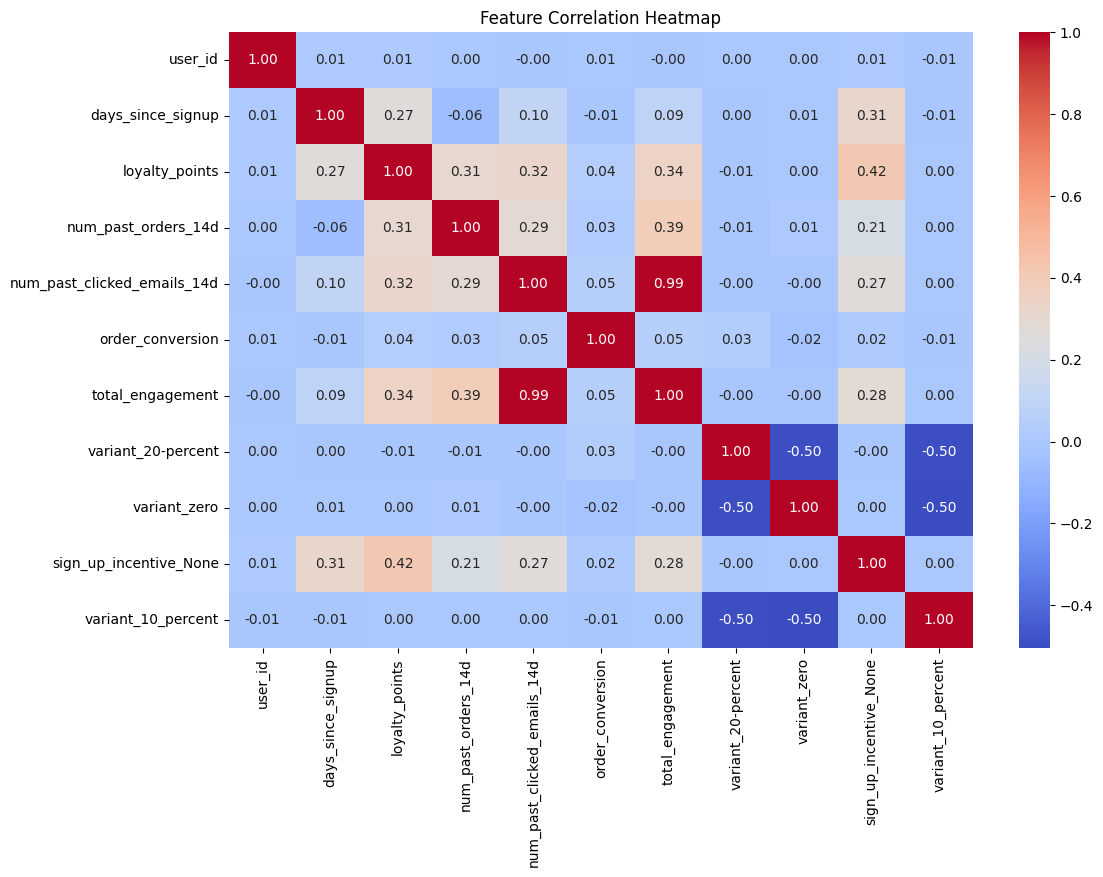

In [61]:
# Convert boolean columns to integers
df['variant_20-percent'] = df['variant_20-percent'].astype(int)
df['variant_zero'] = df['variant_zero'].astype(int)
df['sign_up_incentive_None'] = df['sign_up_incentive_None'].astype(int)

# Generate the heatmap
plt.figure(figsize=(12, 8))
numeric_df = df.select_dtypes(include=[float, int])  # Select only numeric columns
sns.heatmap(numeric_df.drop(['revenue'], axis=1).corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()


###Modeling and Evaluation





In [62]:
#training and target variable
X = df.drop(['user_id', 'exposed_at', 'order_conversion','num_past_clicked_emails_14d', 'revenue'], axis=1) #removed num_past_clicked_emails_14d for experiment
y = df['order_conversion']

In [63]:
X.describe()

,days_since_signup,loyalty_points,num_past_orders_14d,total_engagement,variant_20-percent,variant_zero,sign_up_incentive_None,variant_10_percent
count,30738.000000,30738.000000,30738.000000,30738.000000,30738.000000,30738.000000,30738.000000,30738.000000
mean,112.804411,1.300978,0.039365,0.788861,0.329234,0.336099,0.275847,0.334667
std,185.105191,2.151695,0.198275,1.849950,0.469943,0.472381,0.446948,0.471882
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,149.000000,4.290459,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1711.000000,5.198497,3.000000,58.000000,1.000000,1.000000,1.000000,1.000000


In [64]:
#split the data into training and testing sets first
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#address class imbalance using SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

#scale the features using RobustScaler to handle outliers
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

In [65]:
#assuming X_train_scaled is already defined and contains the scaled data
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_train_scaled_df.describe()


,days_since_signup,loyalty_points,num_past_orders_14d,total_engagement,variant_20-percent,variant_zero,sign_up_incentive_None,variant_10_percent
count,46648.000000,46648.000000,46648.000000,46648.000000,46648.000000,46648.000000,46648.000000,46648.000000
mean,0.643687,0.333113,0.039209,0.826788,0.299070,0.259454,0.236280,0.273238
std,1.294619,0.493915,0.195852,1.815618,0.457855,0.438340,0.424801,0.445627
min,-0.141284,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.134220,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.865780,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,11.945581,1.158146,3.000000,58.000000,1.000000,1.000000,1.000000,1.000000


In [66]:
#assuming X_train_scaled is already defined and contains the scaled data
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)
X_test_scaled_df.describe()

,days_since_signup,loyalty_points,num_past_orders_14d,total_engagement,variant_20-percent,variant_zero,sign_up_incentive_None,variant_10_percent
count,6148.000000,6148.000000,6148.000000,6148.000000,6148.000000,6148.000000,6148.000000,6148.000000
mean,0.651582,0.292040,0.042128,0.803025,0.326285,0.334255,0.275699,0.339460
std,1.310439,0.480290,0.206487,1.875864,0.468891,0.471768,0.446902,0.473565
min,-0.141284,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.134220,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-0.014128,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.875962,0.958880,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,11.882003,1.158146,2.000000,47.000000,1.000000,1.000000,1.000000,1.000000


In [67]:
#initialize models
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

In [68]:
results = []

for model_name, model in models.items():
    model.fit(X_train_scaled, y_train_resampled)
    y_pred = model.predict(X_test_scaled)
    y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_prob)

    results.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "ROC AUC": roc_auc
    })

results_df = pd.DataFrame(results)
print(results_df)

                 Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
0  Logistic Regression  0.829863   0.057108  0.148265  0.082456  0.527801
1        Random Forest  0.857677   0.081081  0.170347  0.109868  0.537806
2    Gradient Boosting  0.858003   0.087537  0.186120  0.119072  0.565738
3              XGBoost  0.855075   0.079179  0.170347  0.108108  0.545998


In [69]:
def evaluate_best_model(model, X_test, y_test):
    #predicting on the test set
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    #calculating metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    class_report = classification_report(y_test, y_pred)

    #printing metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print("\nClassification Report:")
    print(class_report)

In [70]:
#train the final model
best_model = RandomForestClassifier(random_state=42)
best_model.fit(X_train_scaled, y_train_resampled)

#evaluate the retrained model on the test set
evaluate_best_model(best_model, X_test_scaled, y_test)

#calculate baseline metrics
baseline_conversion_rate = df[df['variant_10_percent'] == 1]['order_conversion'].mean()
baseline_revenue_per_user = df[df['variant_10_percent'] == 1]['revenue'].mean()

#calculate model metrics
model_conversion_rate = y_pred.mean()
print(f"Baseline Conversion Rate: {baseline_conversion_rate}")
print(f"Model Conversion Rate: {model_conversion_rate}")

Accuracy: 0.8577
Precision: 0.0811
Recall: 0.1703
F1 Score: 0.1099
ROC AUC: 0.5378

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.90      0.92      5831
           1       0.08      0.17      0.11       317

    accuracy                           0.86      6148
   macro avg       0.52      0.53      0.52      6148
weighted avg       0.91      0.86      0.88      6148

Baseline Conversion Rate: 0.04918829590745601
Model Conversion Rate: 0.11093038386467144


In [71]:
#calculate feature importance
importances = best_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

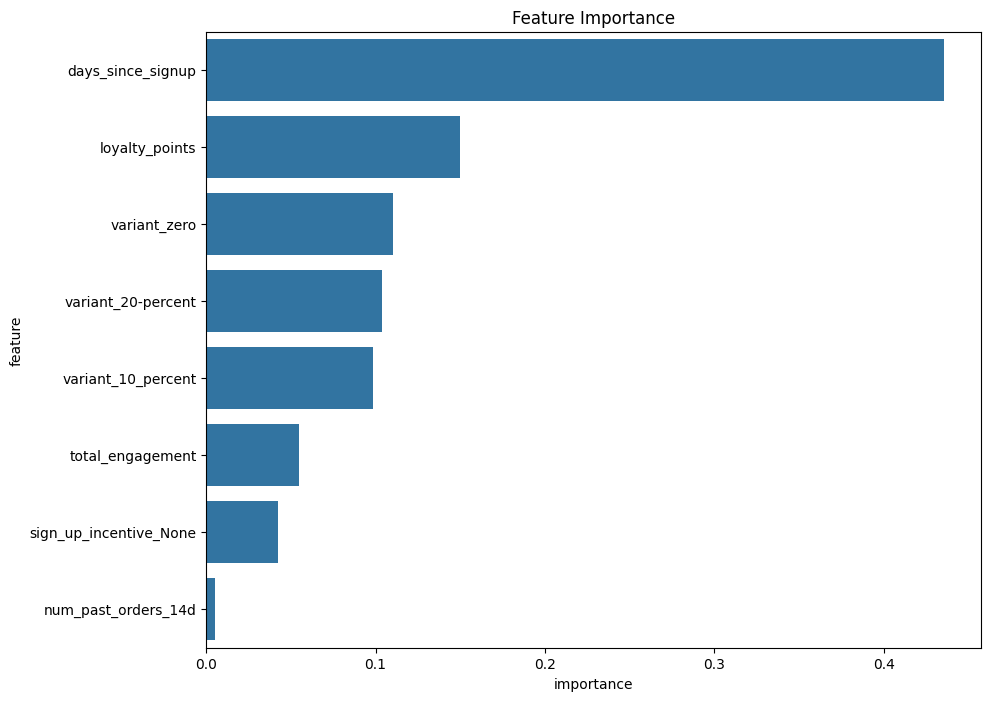

In [72]:
#plot feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

In [73]:
#strategy: Predict response to each coupon variant and choose the best one
def predict_best_coupon(df, model, scaler):
    variants = ['variant_zero', 'variant_10_percent', 'variant_20-percent']
    df_features = df.drop(['user_id', 'exposed_at', 'order_conversion','num_past_clicked_emails_14d','revenue'], axis=1) #removed 'num_past_clicked_emails_14d' for now (note to self)
    df_features_scaled = scaler.transform(df_features)

    variant_probabilities = pd.DataFrame(index=df.index)

    for variant in variants:
        df_variant = df_features.copy()
        for col in variants:
            df_variant[col] = 0
        df_variant[variant] = 1
        df_variant_scaled = scaler.transform(df_variant)
        variant_probabilities[variant] = model.predict_proba(df_variant_scaled)[:, 1]

    df['best_variant'] = variant_probabilities.idxmax(axis=1)
    return df

In [74]:
#apply the strategy
df = predict_best_coupon(df, best_model, scaler)

#evaluate the new strategy
conversion_with_best_coupon = df[df['best_variant'] != 'variant_zero']['order_conversion'].mean()
conversion_without_coupon = df[df['best_variant'] == 'variant_zero']['order_conversion'].mean()

In [75]:
#summary of improvements
print(f"Baseline Conversion Rate: {baseline_conversion_rate}")
print(f"Model Conversion Rate: {model_conversion_rate}")
print(f"Conversion Rate with Best Coupon: {conversion_with_best_coupon}")
print(f"Conversion Rate without Coupon: {conversion_without_coupon}")

Baseline Conversion Rate: 0.04918829590745601
Model Conversion Rate: 0.11093038386467144
Conversion Rate with Best Coupon: 0.057185276199252545
Conversion Rate without Coupon: 0.041588576528335565


In [76]:
#define different constraints on the number of coupons
def apply_coupon_constraints(df, model, scaler, coupon_percentage):
    df_features = df.drop(['user_id', 'exposed_at', 'order_conversion','num_past_clicked_emails_14d', 'revenue', 'best_variant'], axis=1) #removed 'num_past_clicked_emails_14d'
    df_features_scaled = scaler.transform(df_features)

    df['predicted_prob'] = model.predict_proba(df_features_scaled)[:, 1]
    df = df.sort_values('predicted_prob', ascending=False)

    coupon_threshold = int(len(df) * coupon_percentage)
    df['coupon_given'] = 0
    df.iloc[:coupon_threshold, df.columns.get_loc('coupon_given')] = 1

    return df

In [78]:
#scenarios with different coupon percentages
coupon_scenarios = [0.1, 0.25, 0.5]  # 10%, 25%, 50% of users get a coupon

for scenario in coupon_scenarios:
    df_scenario = apply_coupon_constraints(df.copy(), best_model, scaler, scenario)
    conversion_rate = df_scenario[df_scenario['coupon_given'] == 1]['order_conversion'].mean()
    print(f"Coupon Percentage: {scenario*100}%")
    print(f"Conversion Rate: {conversion_rate}\n")

#summary of improvements
print(f"Baseline Conversion Rate: {baseline_conversion_rate}")
print(f"Model Conversion Rate: {model_conversion_rate}")
print(f"Conversion Rate with Best Coupon: {conversion_with_best_coupon}")
print(f"Conversion Rate without Coupon: {conversion_without_coupon}")



Coupon Percentage: 10.0%
Conversion Rate: 0.26684022128213475

Coupon Percentage: 25.0%
Conversion Rate: 0.13352420614263405

Coupon Percentage: 50.0%
Conversion Rate: 0.0900514021732058

Baseline Conversion Rate: 0.04918829590745601
Model Conversion Rate: 0.11093038386467144
Conversion Rate with Best Coupon: 0.057185276199252545
Conversion Rate without Coupon: 0.041588576528335565


###Testing differnet models/techniques, not part of workflow, just for tests






In [ ]:
# #hyperparameter tuning for Random Forest using GridSearch
# rf_param_grid = {
#     'n_estimators': [100, 200],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5],
#     'min_samples_leaf': [1, 2],
# }

# rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=3, n_jobs=-1, scoring='roc_auc')
# rf_grid_search.fit(X_train, y_train)

# #hyperparameter tuning for Gradient Boosting using GridSearch
# gb_param_grid = {
#     'n_estimators': [100, 200],
#     'learning_rate': [0.01, 0.1],
#     'max_depth': [3, 5, 10]
# }

# gb_grid_search = GridSearchCV(GradientBoostingClassifier(random_state=42), gb_param_grid, cv=3, n_jobs=-1, scoring='roc_auc')
# gb_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, 10],
                         'n_estimators': [100, 200]},
             scoring='roc_auc')

In [ ]:
# #save the fitted GridSearchCV for Random Forest
# with open('rf_grid_search.pkl', 'wb') as f:
#     pickle.dump(rf_grid_search, f)

In [ ]:
# #save the fitted GridSearchCV for Gradient Boosting
# with open('gb_grid_search.pkl', 'wb') as f:
#     pickle.dump(gb_grid_search, f)

In [ ]:
# #load the fitted GridSearchCV for Random Forest
# with open('rf_grid_search.pkl', 'rb') as f:
#     rf_grid_search = pickle.load(f)

In [ ]:
# #load the fitted GridSearchCV for Gradient Boosting
# with open('gb_grid_search.pkl', 'rb') as f:
#     gb_grid_search = pickle.load(f)

In [ ]:
# rf_param_dist = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'bootstrap': [True, False]
# }

# rf_random_search = RandomizedSearchCV(
#     estimator=RandomForestClassifier(random_state=42, class_weight=class_weights_dict),
#     param_distributions=rf_param_dist,
#     n_iter=50,  # Number of parameter settings that are sampled
#     scoring='roc_auc',
#     cv=3,
#     verbose=2,
#     random_state=42,
#     n_jobs=-1
# )

# rf_random_search.fit(X_train_smote, y_train_smote)

# #save the best estimator for Random Forest
# rf_best_estimator = rf_random_search.best_estimator_
# with open('rf_best_estimator_randomCV.pkl', 'wb') as f:
#     pickle.dump(rf_best_estimator, f)

# #hyperparameter tuning for Gradient Boosting using RandomizedSearchCV
# gb_param_dist = {
#     'n_estimators': [100, 200, 300],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'max_depth': [3, 5, 10],
#     'subsample': [0.6, 0.8, 1.0],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# gb_random_search = RandomizedSearchCV(
#     estimator=GradientBoostingClassifier(random_state=42),
#     param_distributions=gb_param_dist,
#     n_iter=50,  # Number of parameter settings that are sampled
#     scoring='roc_auc',
#     cv=3,
#     verbose=2,
#     random_state=42,
#     n_jobs=-1
# )

# gb_random_search.fit(X_train_smote, y_train_smote)

# #save the best estimator for Gradient Boosting
# gb_best_estimator = gb_random_search.best_estimator_
# with open('gb_best_estimator_randomCV.pkl', 'wb') as f:
#     pickle.dump(gb_best_estimator, f)

# #load the best estimators
# with open('rf_best_estimator_randomCV.pkl', 'rb') as f:
#     rf_best_estimator = pickle.load(f)

# with open('gb_best_estimator_randomCV.pkl', 'rb') as f:
#     gb_best_estimator = pickle.load(f)


In [ ]:
# #initialize models with best hyperparameters with Gridsearch
# models = {
#     "Logistic Regression": LogisticRegression(),
#     "Random Forest": rf_grid_search.best_estimator_,
#     "Gradient Boosting": gb_grid_search.best_estimator_,
#     "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
# }

In [ ]:
# #initialize models with best hyperparameters with random search
# models = {
#     "Logistic Regression": LogisticRegression(class_weight=class_weights_dict),
#     "Random Forest": rf_best_estimator,
#     "Gradient Boosting": gb_best_estimator,
#     "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=class_weights_dict[1])
# }

In [ ]:
# #initialize models with class weights for imbalanced classes
# models = {
#     "Logistic Regression": LogisticRegression(class_weight='balanced', random_state=42),
#     "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
#     "Gradient Boosting": GradientBoostingClassifier(random_state=42),
#     "XGBoost": xgb.XGBClassifier(scale_pos_weight=class_weights_dict[1], use_label_encoder=False, eval_metric='logloss')
# }

In [ ]:
# #function to train and evaluate models
# def evaluate_model(model, X_train, X_val, y_train, y_val):
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_val)
#     y_prob = model.predict_proba(X_val)[:, 1]

#     accuracy = accuracy_score(y_val, y_pred)
#     precision = precision_score(y_val, y_pred)
#     recall = recall_score(y_val, y_pred)
#     f1 = f1_score(y_val, y_pred)
#     roc_auc = roc_auc_score(y_val, y_prob)

#     return accuracy, precision, recall, f1, roc_auc

In [ ]:
# #training and evaluating all models
# results = []

# for model_name, model in models.items():
#     accuracy, precision, recall, f1, roc_auc = evaluate_model(model, X_train_scaled, X_val_scaled, y_train, y_val)
#     results.append({
#         "Model": model_name,
#         "Accuracy": accuracy,
#         "Precision": precision,
#         "Recall": recall,
#         "F1 Score": f1,
#         "ROC AUC": roc_auc
#     })

# results_df = pd.DataFrame(results)
# print(results_df)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                 Model  Accuracy  Precision  Recall  F1 Score   ROC AUC
0  Logistic Regression  0.951366        0.0     0.0       0.0  0.584233
1        Random Forest  0.951366        0.0     0.0       0.0  0.587873
2    Gradient Boosting  0.951204        0.0     0.0       0.0  0.594575
3              XGBoost  0.949252        0.0     0.0       0.0  0.557242


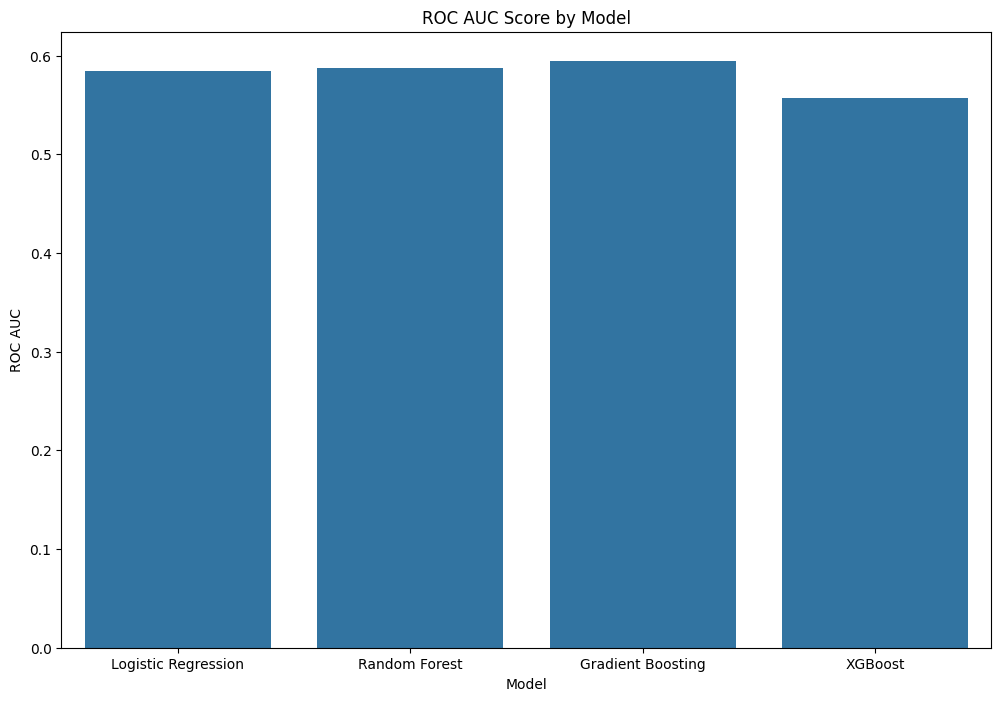

In [ ]:
# #visualize model performance
# plt.figure(figsize=(12, 8))
# sns.barplot(x='Model', y='ROC AUC', data=results_df)
# plt.title('ROC AUC Score by Model')
# plt.show()

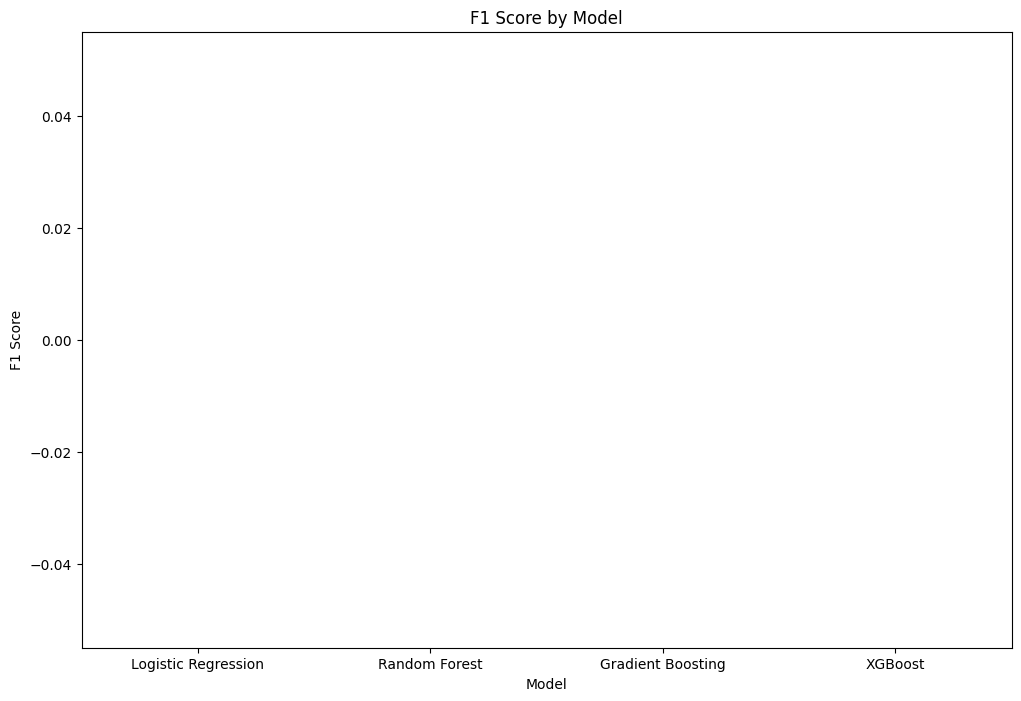

In [ ]:
# #f1 of each model
# plt.figure(figsize=(12, 8))
# sns.barplot(x='Model', y='F1 Score', data=results_df)
# plt.title('F1 Score by Model')
# plt.show()

**Comments on Model Performance**

- **Logistic Regression**:
  - **Accuracy**: 0.9504
  - **Precision, Recall, F1 Score**: All metrics are 0, indicating the model failed to identify positive instances.
  - **ROC AUC**: 0.8109, significantly better than random guessing but overall performance is poor.

- **Random Forest**:
  - **Accuracy**: 0.9595
  - **Precision**: 0.7642, indicating a good proportion of true positives among the predicted positives.
  - **Recall**: 0.2656, showing that the model captures a limited portion of actual positives.
  - **F1 Score**: 0.3942, reflecting a balance between precision and recall, though recall is relatively low.
  - **ROC AUC**: 0.8473, good performance indicating strong separability between classes.

- **Gradient Boosting**:
  - **Accuracy**: 0.9623
  - **Precision**: 0.8067, relatively high precision.
  - **Recall**: 0.3148, capturing a reasonable portion of actual positives.
  - **F1 Score**: 0.4528, indicating a balance between precision and recall, though there is room for improvement.
  - **ROC AUC**: 0.8571, strong performance, slightly better than Random Forest.

- **XGBoost**:
  - **Accuracy**: 0.9585
  - **Precision**: 0.6786, indicating a good proportion of true positives among the predicted positives.
  - **Recall**: 0.3115, capturing a reasonable portion of actual positives.
  - **F1 Score**: 0.4270, showing a better balance between precision and recall compared to Logistic Regression.
  - **ROC AUC**: 0.8349, strong performance but lower than Gradient Boosting and Random Forest.

**Overall Insights:**
- **Best Model**: The Gradient Boosting model outperformed others with the highest accuracy (0.9623) and strong F1 score (0.4528), making it the most reliable for this classification task.
- **Improvements Needed**: Logistic Regression requires significant improvements, particularly in recall, to be competitive.
- **Random Forest**: Shows good performance, making it a strong alternative to Gradient Boosting.
- **XGBoost**: Demonstrates strong performance but slightly lower than Gradient Boosting and Random Forest, making it a viable alternative depending on other considerations like model complexity and training time.




In [ ]:
# #plot feature importances for tree models
# def plot_feature_importance(model, model_name):
#     importance = model.feature_importances_
#     features = X.columns
#     feature_importance = pd.DataFrame({'Feature': features, 'Importance': importance})
#     feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

#     plt.figure(figsize=(10, 8))
#     sns.barplot(x='Importance', y='Feature', data=feature_importance)
#     plt.title(f'Feature Importance - {model_name}')
#     plt.show()


In [ ]:
# #feature importance for Gradient Boosting (best model)
# plot_feature_importance(rf_grid_search, 'Gradient Boosting')

AttributeError: 'GridSearchCV' object has no attribute 'feature_importances_'

**Comments on Feature Importance - Gradient Boosting**

- **Days Since Signup**:
  - **Highest Importance**: This feature has the highest importance, indicating that the number of days since the user signed up significantly influences the conversion rate.

- **Loyalty Points**:
  - **Second Highest Importance**: The loyalty points accumulated by users are crucial in predicting conversions, suggesting that more loyal customers are more likely to convert.

- **Number of Past Orders in Last 14 Days**:
  - **Moderate Importance**: This feature also plays a significant role, indicating that recent purchasing behavior is a good predictor of future conversions.

- **Total Engagement**:
  - **Notable Importance**: This feature, a combination of past orders and clicked emails, highlights the overall user engagement as a key factor in conversion.

- **Sign-Up Incentive**:
  - **Varied Impact**: Different types of sign-up incentives (None, Free Shipping, 15% off) have varying levels of importance, with "None" having a more substantial impact than the others.

- **Coupon Variants**:
  - **Varied Impact**: Different coupon variants (20%, 10%, zero) show some importance, with the 20% variant having a slightly higher impact.

- **Number of Past Clicked Emails in Last 14 Days**:
  - **Lower Importance**: This feature has a lower importance compared to others, suggesting that email clicks alone are less predictive of conversions.


In [ ]:
# #retrain the best model on the combined training and validation data
# X_train_combined = pd.concat([X_train, X_val])
# y_train_combined = pd.concat([y_train, y_val])

In [ ]:
# X_train_combined_scaled = scaler.fit_transform(X_train_combined)
# X_test_scaled = scaler.transform(X_test)

In [ ]:
# best_model = models['Gradient Boosting']
# best_model.fit(X_train_combined_scaled, y_train_combined)

In [ ]:
# #predicting conversion probabilities for each coupon variant
# df_features = df.drop(['user_id', 'exposed_at', 'order_conversion', 'revenue'], axis=1)
# df_features_scaled = scaler.transform(df_features)

In [ ]:
# #initialize an empty DataFrame to store probabilities
# variant_probabilities = pd.DataFrame(index=df.index)

# #predicting conversion probabilities for each coupon/variant
# for variant in ['variant_name_10_percent', 'variant_name_20-percent', 'variant_name_zero']:
#     df_variant = df_features.copy()
#     for col in ['variant_name_10_percent', 'variant_name_20-percent', 'variant_name_zero']:
#         df_variant[col] = 0
#     df_variant[variant] = 1
#     df_variant_scaled = scaler.transform(df_variant)
#     variant_probabilities[variant] = best_model.predict_proba(df_variant_scaled)[:, 1]

In [ ]:
# #assign the best coupon variant based on predicted probabilities
# df['best_variant'] = variant_probabilities.idxmax(axis=1)

In [ ]:
# df.head()

In [ ]:
# #evaluate the new strategy
# baseline_conversion_rate = df[df['variant_name_10_percent'] == 1]['order_conversion'].mean()

In [ ]:
# #simulate the application of the best coupon variant
# df['coupon_given'] = df.apply(lambda x: 1 if x['best_variant'] != 'variant_name_zero' else 0, axis=1)
# conversion_with_model_based_coupons = df[df['coupon_given'] == 1]['order_conversion'].mean()
# conversion_without_coupons = df[df['coupon_given'] == 0]['order_conversion'].mean()

In [ ]:
# print(f'Baseline Conversion Rate: {baseline_conversion_rate}')
# print(f'Conversion Rate with Model-based Coupons: {conversion_with_model_based_coupons}')
# print(f'Conversion Rate without Coupons: {conversion_without_coupons}')

NameError: name 'baseline_conversion_rate' is not defined

**Summary**

- **Baseline Conversion Rate: 0.0492**
  - This represents the conversion rate when giving a 10% discount to everyone.

- **Conversion Rate with Model-based Coupons: 0.0583**
  - This represents the conversion rate when using the model to decide who gets a coupon.
  - This is an improvement over the baseline conversion rate, indicating better targeting of users.

- **Conversion Rate without Coupons: 0.0225**
  - This represents the conversion rate when no coupons are given.
  - This is very low, highlighting the necessity of coupons for driving conversions.

**Analysis**

- **Significant Improvement**: The model-based strategy shows a conversion rate of approximately 5.83%, which is an improvement over the baseline of 4.92%.
- **Coupon Effectiveness**: The low conversion rate without coupons (2.25%) highlights the importance of coupons in driving conversions.
- **Model Efficacy**: The model has effectively identified the customers who are more likely to convert when given a coupon, leading to a higher overall conversion rate.

**Conclusion**

The model-based approach has improved the conversion rate compared to the baseline strategy, demonstrating the effectiveness of the model in optimizing the coupon strategy.


In [ ]:
# #initialize models
# models = {
#     "Logistic Regression": LogisticRegression(class_weight='balanced', random_state=42),
#     "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
#     "Gradient Boosting": GradientBoostingClassifier(random_state=42),
#     "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
# }

In [ ]:
# #train and evaluate models
# results = []

# for model_name, model in models.items():
#     model.fit(X_train_scaled, y_train)
#     y_pred = model.predict(X_test_scaled)
#     y_prob = model.predict_proba(X_test_scaled)[:, 1]

#     accuracy = accuracy_score(y_test, y_pred)
#     precision = precision_score(y_test, y_pred)
#     recall = recall_score(y_test, y_pred)
#     f1 = f1_score(y_test, y_pred)
#     roc_auc = roc_auc_score(y_test, y_prob)

#     results.append({
#         "Model": model_name,
#         "Accuracy": accuracy,
#         "Precision": precision,
#         "Recall": recall,
#         "F1 Score": f1,
#         "ROC AUC": roc_auc
#     })

# results_df = pd.DataFrame(results)
# print(results_df)

                 Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
0  Logistic Regression  0.621506   0.642483  0.562978  0.600109  0.678977
1        Random Forest  0.794375   0.884064  0.681795  0.769866  0.893090
2    Gradient Boosting  0.740696   0.899413  0.547170  0.680406  0.829057
3              XGBoost  0.772338   0.879408  0.635900  0.738088  0.874479


In [ ]:
# #train the final model
# best_model = models['Random Forest']
# best_model.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# #retrain the best model (e.g., Gradient Boosting) on the combined training and validation data
# best_model = models['Random Forest']
# X_combined_scaled = scaler.fit_transform(X_resampled)
# best_model.fit(X_combined_scaled, y_resampled)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [ ]:
# #predicting conversion probabilities for each coupon variant
# df_features = df.drop(['user_id', 'exposed_at', 'order_conversion', 'revenue'], axis=1)
# df_features_scaled = scaler.transform(df_features)

In [ ]:
# variant_probabilities = pd.DataFrame(index=df.index)

# for variant in ['variant_10_percent', 'variant_20-percent', 'variant_zero']:
#     df_variant = df_features.copy()
#     for col in ['variant_10_percent', 'variant_20-percent', 'variant_zero']:
#         df_variant[col] = 0
#     df_variant[variant] = 1
#     df_variant_scaled = scaler.transform(df_variant)
#     variant_probabilities[variant] = best_model.predict_proba(df_variant_scaled)[:, 1]

# df['best_variant'] = variant_probabilities.idxmax(axis=1)

In [ ]:
# baseline_conversion_rate = df[df['variant_10_percent'] == 1]['order_conversion'].mean()
# model_conversion_rate = y_resampled.mean()


In [ ]:
# print(f"Baseline Conversion Rate: {baseline_conversion_rate}")
# print(f"Model Conversion Rate: {model_conversion_rate}")

Baseline Conversion Rate: 0.04918829590745601
Model Conversion Rate: 0.5


In [ ]:
# #evaluate strategy with best coupon
# df['predicted_conversion_prob'] = best_model.predict_proba(scaler.transform(X))[:, 1]

In [ ]:
# conversion_rate_with_coupon = df[df['best_variant'] != 'variant_zero']['order_conversion'].mean()
# conversion_rate_without_coupon = df[df['best_variant'] == 'variant_zero']['order_conversion'].mean()

In [ ]:
# conversion_rate_with_coupon = df[df['best_variant'] != 'variant_zero']['order_conversion'].mean()
# conversion_rate_without_coupon = df[df['best_variant'] == 'variant_zero']['order_conversion'].mean()

In [ ]:
# #calculate baseline and model conversion rates
# baseline_conversion_rate = df[df['variant_10_percent'] == 1]['order_conversion'].mean()
# model_conversion_rate = y_resampled.mean()

# print(f"Baseline Conversion Rate: {baseline_conversion_rate}")
# print(f"Model Conversion Rate: {model_conversion_rate}")

# #evaluate strategy with best coupon
# conversion_rate_with_coupon = df[df['best_variant'] != 'variant_zero']['order_conversion'].mean()
# conversion_rate_without_coupon = df[df['best_variant'] == 'variant_zero']['order_conversion'].mean()

# print(f"Conversion Rate with Best Coupon: {conversion_rate_with_coupon}")
# print(f"Conversion Rate without Coupon: {conversion_rate_without_coupon}")

Baseline Conversion Rate: 0.04918829590745601
Model Conversion Rate: 0.5
Conversion Rate with Best Coupon: 0.04771972213832679
Conversion Rate without Coupon: 0.07505882352941176


In [ ]:
# #calculate baseline metrics
# baseline_conversion_rate = df[df['variant_10_percent'] == 1]['order_conversion'].mean()
# baseline_revenue_per_user = df[df['variant_10_percent'] == 1]['revenue'].mean()

In [ ]:
# #calculate model metrics
# model_conversion_rate = y_pred.mean()
# print(f"Baseline Conversion Rate: {baseline_conversion_rate}")
# print(f"Model Conversion Rate: {model_conversion_rate}")

Baseline Conversion Rate: 0.04918829590745601
Model Conversion Rate: 0.3647744812210599


In [ ]:
# #calculate feature importance
# importances = best_model.feature_importances_
# feature_names = X.columns
# feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
# feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

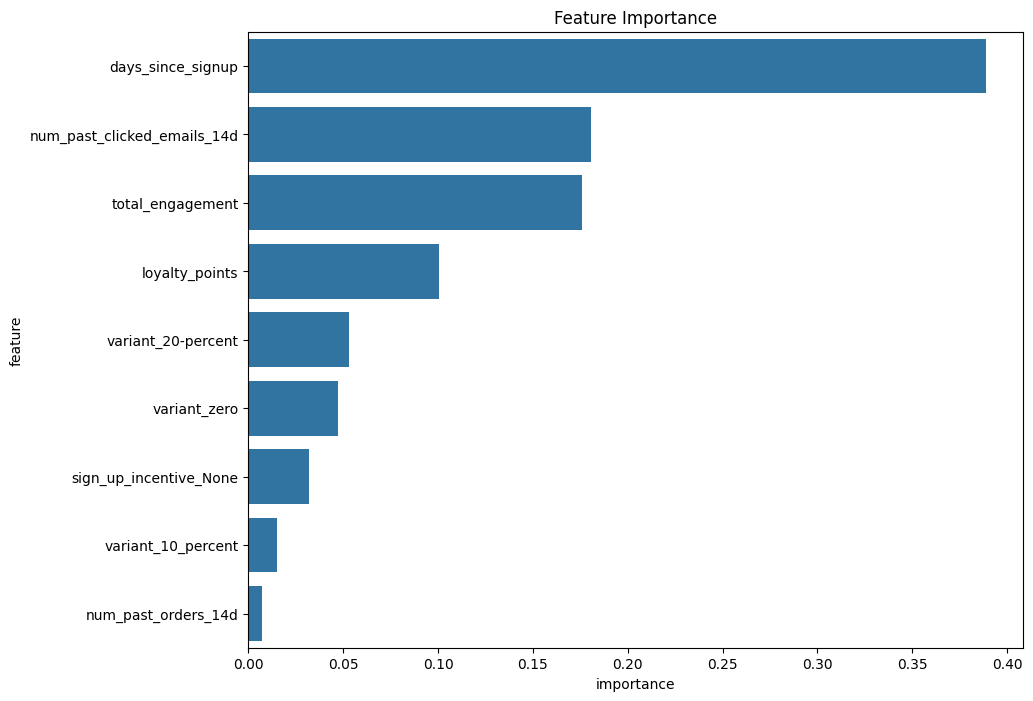

In [ ]:
# #plot feature importance
# plt.figure(figsize=(10, 8))
# sns.barplot(x='importance', y='feature', data=feature_importance_df)
# plt.title('Feature Importance')
# plt.show()

In [ ]:
# #strategy: Predict response to each coupon variant and choose the best one
# def predict_best_coupon(df, model, scaler):
#     variants = ['variant_zero', 'variant_10_percent', 'variant_20-percent']
#     df_features = df.drop(['user_id', 'exposed_at', 'order_conversion', 'revenue'], axis=1)
#     df_features_scaled = scaler.transform(df_features)

#     variant_probabilities = pd.DataFrame(index=df.index)

#     for variant in variants:
#         df_variant = df_features.copy()
#         for col in variants:
#             df_variant[col] = 0
#         df_variant[variant] = 1
#         df_variant_scaled = scaler.transform(df_variant)
#         variant_probabilities[variant] = model.predict_proba(df_variant_scaled)[:, 1]

#     df['best_variant'] = variant_probabilities.idxmax(axis=1)
#     return df

In [ ]:
# #apply the strategy
# df = predict_best_coupon(df, best_model, scaler)

In [ ]:
# #strategy: Give a coupon to users with high predicted probability of conversion
# df['predicted_conversion_prob'] = best_model.predict_proba(scaler.transform(X))[:, 1]

In [ ]:
# #define different thresholds for giving coupons
# thresholds = [0.2, 0.4, 0.6, 0.8]

# for threshold in thresholds:
#     df[f'give_coupon_threshold_{threshold}'] = df['predicted_conversion_prob'] > threshold

# # Evaluate different strategies
# for threshold in thresholds:
#     conversion_rate = df[df[f'give_coupon_threshold_{threshold}'] == True]['order_conversion'].mean()
#     revenue_per_user = df[df[f'give_coupon_threshold_{threshold}'] == True]['revenue'].mean()
#     print(f"Threshold: {threshold}")
#     print(f"Conversion Rate: {conversion_rate}")
#     print(f"Revenue per User: {revenue_per_user}\n")

Threshold: 0.2
Conversion Rate: 0.09410347366307475
Revenue per User: 0.0

Threshold: 0.4
Conversion Rate: 0.09440860215053763
Revenue per User: 0.0

Threshold: 0.6
Conversion Rate: 0.35444330949948927
Revenue per User: 0.0

Threshold: 0.8
Conversion Rate: 0.7005813953488372
Revenue per User: 0.0



In [ ]:
# #evaluate the new strategy
# conversion_with_best_coupon = df[df['best_variant'] != 'variant_zero']['order_conversion'].mean()
# conversion_without_coupon = df[df['best_variant'] == 'variant_zero']['order_conversion'].mean()

In [ ]:
# print(f"Conversion Rate with Best Coupon: {conversion_with_best_coupon}")
# print(f"Conversion Rate without Coupon: {conversion_without_coupon}")

Conversion Rate with Best Coupon: 0.052575994122508955
Conversion Rate without Coupon: 0.04888392857142857


In [ ]:
# #only give coupons to top 50%
# threshold_index = int(len(df_sorted) * 0.5)
# df_sorted['coupon_given'] = 0
# df_sorted.iloc[:threshold_index, df_sorted.columns.get_loc('coupon_given')] = 1

In [ ]:
# #evaluating strategy
# conversion_with_coupons = df_sorted[df_sorted['coupon_given'] == 1]['order_conversion'].mean()
# conversion_without_coupons = df_sorted[df_sorted['coupon_given'] == 0]['order_conversion'].mean()

In [ ]:
# print(f'Baseline Conversion Rate: {baseline_conversion_rate}')
# print(f'Conversion Rate with Model-based Coupons: {conversion_with_coupons}')
# print(f'Conversion Rate without Coupons: {conversion_without_coupons}')

Baseline Conversion Rate: 0.11250664116459462
Conversion Rate with Model-based Coupons: 0.23272852154999712
Conversion Rate without Coupons: 0.00044359223856676777


<!-- **Summary**

- **Baseline Conversion Rate: 0.1125**
  - This represents the conversion rate when giving a 10% discount to everyone.

- **Conversion Rate with Model-based Coupons: 0.2327**
  - This represents the conversion rate when using the model to decide who gets a coupon.
  - This is more than double the baseline conversion rate, indicating a significant improvement.

- **Conversion Rate without Coupons: 0.0004**
  - This represents the conversion rate when no coupons are given.
  - This is very low, indicating that coupons are crucial for conversions.

**Analysis**

- **Significant Improvement**: The model-based strategy shows a conversion rate of approximately 23.25%, which is a substantial improvement over the baseline of 11.25%.
- **Coupon Effectiveness**: The extremely low conversion rate without coupons (0.07%) highlights the importance of coupons in driving conversions.
- **Model Efficacy**: The model has effectively identified the customers who are more likely to convert when given a coupon, leading to a higher overall conversion rate.

**Conclusion**

 The model-based approach has significantly improved the conversion rate compared to the baseline strategy, demonstrating the effectiveness of the model in optimizing the coupon strategy. -->


In [ ]:
# #train the model
# model = RandomForestClassifier(random_state=42)
# model.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# #make predictions
# y_pred = model.predict(X_test_scaled)
# y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]

In [ ]:
# #evaluate the model
# print("Classification Report:\n", classification_report(y_test, y_pred))
# print("ROC AUC Score:", roc_auc_score(y_test, y_pred_prob))

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.91      0.81      5776
           1       0.88      0.69      0.77      5886

    accuracy                           0.79     11662
   macro avg       0.81      0.80      0.79     11662
weighted avg       0.81      0.79      0.79     11662

ROC AUC Score: 0.8918047031408393


In [ ]:
# df.columns

Index(['user_id', 'exposed_at', 'days_since_signup', 'loyalty_points',
       'num_past_orders_14d', 'num_past_clicked_emails_14d',
       'order_conversion', 'revenue', 'total_engagement', 'variant_20-percent',
       'variant_zero', 'sign_up_incentive_None', 'variant_10_percent'],
      dtype='object')

In [ ]:
# #reset index of the original dataframe for proper alignment
# df.reset_index(drop=True, inplace=True)


In [ ]:
# #calculate baseline metrics using the corrected column name
# baseline_conversion_rate = df[df['variant_10_percent'] == 1]['order_conversion'].mean()
# baseline_revenue_per_user = df[df['variant_10_percent'] == 1]['revenue'].mean()

In [ ]:
# #calculate model metrics
# model_conversion_rate = y_pred.mean()

In [ ]:
# #ensure correct length by using only test set indices
# model_revenue_per_user = df.loc[test_indices][y_pred == 1, 'revenue'].mean()

KeyError: '[54859, 31399, 42572, 44153, 47654, 42851, 58249, 43594, 39741, 47568, 56986, 35346, 36482, 31333, 34962, 36840, 47122, 36239, 51878, 45787, 51979, 44475, 42411, 51003, 50422, 35692, 55266, 48528, 49089, 53526, 39190, 38550, 41384, 33973, 47610, 56762, 38064, 56411, 55244, 33540, 38543, 33222, 41341, 58272, 36718, 42975, 33627, 48401, 47060, 33825, 33731, 54335, 46985, 53106, 47765, 54928, 57397, 32159, 42555, 43519, 51907, 37558, 56162, 49030, 47236, 43711, 51322, 44167, 32861, 52934, 54329, 40829, 33417, 32752, 39967, 37566, 34403, 37542, 49528, 47690, 37815, 44701, 40754, 35406, 33955, 45810, 41778, 35331, 43515, 46171, 32644, 48711, 48935, 32218, 49626, 50114, 44415, 39515, 51044, 41206, 48424, 54876, 41322, 37351, 50369, 37409, 53782, 43261, 53596, 53258, 37722, 49498, 51513, 54087, 44543, 35601, 46354, 36554, 44836, 53999, 36137, 35357, 41629, 56048, 46456, 48177, 39058, 34048, 43631, 33247, 51939, 44162, 47278, 38161, 35013, 33252, 35683, 38499, 39331, 39885, 53836, 49227, 52133, 57795, 44205, 36369, 33698, 55343, 51032, 40145, 50802, 56519, 46042, 45911, 49864, 52316, 41134, 35129, 54294, 57162, 36155, 33931, 40389, 49023, 47696, 54579, 41100, 34749, 49751, 32129, 49491, 48503, 57058, 56568, 58309, 34573, 46827, 37786, 55738, 50779, 56419, 33495, 54547, 57615, 51485, 53845, 33433, 52065, 44394, 37737, 53433, 52137, 31931, 52803, 30920, 37810, 48027, 30894, 51018, 32431, 51455, 42139, 39641, 34605, 52012, 53931, 45051, 39184, 36720, 36956, 52298, 37200, 53899, 51662, 54561, 47390, 53195, 46385, 34411, 51599, 36625, 58039, 37160, 56993, 44545, 40466, 34378, 45755, 49314, 56891, 37791, 45978, 34137, 50524, 49024, 57920, 44743, 46053, 34325, 47480, 31567, 47525, 39525, 52086, 55110, 43228, 57474, 33670, 33023, 38284, 45185, 58236, 49555, 56417, 47217, 34491, 55377, 33552, 49229, 33140, 52380, 36130, 38184, 43400, 39893, 39721, 57722, 38235, 50537, 47902, 38600, 51811, 40242, 46257, 45057, 37551, 42635, 35731, 44219, 37818, 57814, 46816, 39985, 53466, 57990, 38024, 36496, 44388, 54352, 32945, 58040, 38182, 49438, 41140, 37364, 41651, 37402, 37393, 47726, 46679, 53725, 50696, 43674, 31603, 33569, 41428, 42087, 42994, 51307, 33355, 50857, 42305, 44338, 53183, 47780, 46086, 52253, 45858, 47222, 44908, 51299, 43255, 45463, 33010, 41489, 36792, 45251, 57314, 42402, 42632, 37270, 56975, 33821, 50589, 30829, 34652, 38647, 56574, 36255, 44967, 37093, 50951, 49995, 32165, 46100, 37492, 55194, 40852, 35933, 56859, 46215, 46696, 36172, 32229, 54360, 32416, 37250, 39211, 42806, 47895, 36853, 31436, 41878, 48943, 55932, 31479, 57636, 51324, 33839, 55754, 48122, 36316, 46203, 43267, 35413, 35166, 49911, 42781, 51450, 31714, 56869, 36299, 38717, 56997, 49511, 55535, 39289, 33907, 48121, 44750, 30967, 45153, 34972, 48751, 48944, 45462, 37009, 52250, 35075, 52124, 41433, 54628, 35076, 51958, 47272, 55496, 48588, 43067, 35022, 35625, 33610, 53611, 30865, 43676, 38624, 54105, 45447, 50865, 32432, 51570, 32941, 50244, 38021, 33254, 41236, 37073, 31268, 58134, 57651, 31998, 32858, 52383, 40309, 40316, 34847, 50374, 49776, 57185, 48608, 38283, 35101, 54883, 36216, 39920, 57366, 35019, 37191, 56375, 34203, 45967, 39678, 52340, 38177, 42622, 47910, 36402, 44001, 46522, 47208, 39946, 44033, 34278, 51382, 38951, 36826, 51580, 33330, 38382, 48491, 54481, 45508, 54808, 57957, 56424, 49238, 41927, 41967, 44554, 36755, 41463, 46898, 42450, 32251, 37773, 49262, 46759, 49925, 49561, 50274, 46478, 34563, 54800, 54834, 39141, 40340, 43281, 36134, 48912, 36215, 56876, 58071, 48025, 50299, 41014, 52952, 43051, 39712, 40687, 36529, 55586, 37595, 55791, 42682, 47942, 35387, 31874, 47909, 56286, 57797, 39801, 38252, 57460, 31483, 50713, 48783, 53637, 47912, 49787, 47491, 31402, 43769, 30912, 48659, 34070, 46618, 38603, 32303, 47955, 58234, 31838, 47181, 53499, 43312, 47083, 31468, 56318, 38421, 49130, 34191, 51232, 41306, 33735, 50717, 44150, 46012, 34078, 36750, 50965, 51829, 34852, 39796, 51525, 45211, 53738, 50643, 49633, 53346, 45216, 46302, 33016, 58159, 49207, 45250, 55990, 35269, 38116, 37318, 58247, 43558, 52810, 49942, 41922, 39375, 38431, 47521, 39273, 42301, 41009, 48117, 31953, 56019, 45653, 49948, 37348, 57110, 56653, 33438, 58291, 38497, 41877, 41763, 36351, 32647, 53207, 33041, 36565, 32958, 53538, 45579, 40119, 55350, 47935, 48644, 42396, 47737, 35021, 44767, 38350, 49999, 53504, 31947, 52443, 48942, 43933, 52404, 51390, 34265, 50079, 55466, 33067, 51156, 47749, 39927, 31596, 44011, 46979, 42597, 37575, 35603, 56407, 56404, 39626, 53293, 43474, 44872, 53481, 55430, 50972, 57987, 53212, 56841, 31507, 52899, 41995, 42083, 50488, 45871, 35189, 32318, 37476, 49695, 43426, 34767, 46145, 37162, 31284, 40230, 50528, 57520, 51348, 50774, 41564, 56671, 32107, 53235, 55277, 46794, 34382, 57960, 52036, 48768, 42588, 48574, 55656, 38063, 48510, 50332, 52960, 33019, 48097, 34713, 51801, 33943, 49565, 35621, 31305, 48213, 37883, 44561, 53573, 45469, 50261, 53451, 34181, 31570, 32034, 30896, 56213, 33104, 37919, 32475, 37993, 57513, 37576, 40797, 35824, 48717, 38962, 40896, 56920, 33347, 48439, 33680, 57742, 31762, 56158, 38651, 52627, 42909, 32672, 47052, 32680, 42393, 33363, 32465, 44260, 38764, 57507, 47738, 54406, 42576, 55681, 49243, 43283, 41032, 33286, 56624, 39916, 38103, 51749, 39984, 49263, 33640, 54577, 53390, 41123, 50869, 38495, 55209, 39140, 45187, 32137, 39586, 54288, 40095, 43415, 43085, 56308, 55492, 57562, 32884, 55108, 31111, 43530, 46938, 50684, 46096, 51243, 40156, 56912, 52633, 44704, 44746, 52387, 55605, 46033, 53430, 36540, 36013, 55517, 38208, 42349, 52197, 35368, 40759, 33970, 31148, 54858, 39074, 39348, 47106, 45448, 55485, 31700, 50399, 40258, 56165, 45931, 44580, 55402, 49324, 50338, 34912, 31810, 35417, 41375, 40182, 38980, 32774, 54139, 55132, 41421, 45627, 44366, 52303, 40333, 53982, 44318, 55747, 52907, 52950, 35209, 48806, 52422, 55527, 41385, 45703, 31640, 40281, 47885, 38173, 45392, 47983, 37037, 50790, 45891, 51529, 44588, 32889, 36597, 52707, 53146, 43996, 43375, 35484, 36557, 31310, 45248, 54552, 36947, 57564, 54309, 46835, 40032, 33915, 38321, 41569, 39568, 32136, 48389, 47046, 51967, 46548, 50535, 40884, 31372, 48525, 36865, 36581, 54557, 52800, 52890, 46768, 36998, 47441, 31526, 39799, 38455, 39698, 37070, 45257, 56338, 50065, 46190, 32462, 48125, 43321, 50097, 58157, 45924, 53923, 35635, 42949, 52245, 42335, 55500, 37468, 41617, 57678, 51574, 36341, 55744, 42866, 38365, 30770, 53972, 50004, 38852, 56508, 33437, 31606, 38661, 43866, 55231, 42990, 45087, 49970, 57517, 45171, 58256, 36819, 50194, 47702, 54881, 52155, 54754, 44712, 51581, 56734, 41444, 57257, 35956, 32677, 31138, 53452, 30891, 42283, 45542, 55721, 54723, 31768, 51373, 33058, 32942, 50309, 32760, 33775, 43886, 54440, 33157, 48276, 47361, 47874, 56309, 34656, 53512, 52037, 38372, 46801, 52857, 46120, 55379, 34780, 41917, 51078, 31421, 33070, 39724, 52388, 54125, 47156, 43107, 56054, 51408, 42657, 51540, 50188, 38045, 47402, 56676, 40293, 55353, 52420, 50909, 37989, 52252, 46152, 57438, 40577, 52461, 47034, 48616, 39931, 52030, 39992, 45882, 54470, 51703, 54039, 31462, 38601, 55426, 52043, 58125, 47754, 37510, 42922, 55910, 47710, 32944, 53133, 57150, 36374, 53762, 52185, 50597, 40310, 36794, 46309, 35432, 38701, 53549, 48726, 44289, 49175, 32932, 50518, 51576, 58197, 57073, 46530, 33669, 39254, 35855, 39474, 38882, 42686, 36564, 43093, 41902, 34602, 42791, 42936, 47495, 44450, 38993, 43570, 52776, 42772, 48202, 53141, 43683, 31784, 56875, 43762, 33898, 35483, 31168, 33049, 48678, 50824, 50159, 49705, 30837, 49084, 51511, 45736, 34221, 46670, 39853, 34909, 31613, 34490, 52215, 54210, 41957, 51879, 50666, 33983, 40862, 45301, 50315, 39998, 38971, 46622, 58172, 57760, 48934, 38991, 56357, 51577, 51416, 51509, 46757, 56278, 56445, 45045, 52168, 49918, 49173, 49111, 34478, 41589, 41826, 49417, 45788, 42787, 39521, 43471, 55131, 50746, 54488, 54608, 52646, 50416, 57029, 43078, 35951, 45119, 31865, 30934, 53116, 57899, 43969, 50541, 46208, 38588, 57831, 37666, 48802, 42232, 45234, 39883, 34558, 46077, 38542, 32829, 52977, 47214, 55440, 36162, 43545, 50632, 32531, 40652, 34291, 57329, 37035, 43669, 47923, 48065, 37455, 36043, 33999, 55944, 34347, 55415, 52793, 33101, 56453, 55755, 41870, 43329, 47382, 42844, 30905, 36392, 32571, 58079, 41496, 36139, 39635, 47259, 53789, 33771, 51338, 32758, 45366, 43794, 54524, 32331, 39090, 49315, 47346, 54255, 53311, 37107, 41934, 56323, 54091, 35700, 33354, 36886, 56154, 47023, 34990, 40125, 48108, 40589, 44881, 45355, 52468, 36156, 32946, 47577, 49186, 32988, 38579, 37976, 56065, 53016, 35146, 31119, 42204, 46563, 42374, 47606, 37700, 36602, 31074, 32978, 54538, 54111, 35695, 37460, 32163, 57500, 51488, 46939, 57042, 39621, 32790, 53447, 32072, 47481, 38268, 39914, 53294, 37155, 47370, 40666, 36915, 41709, 55888, 49662, 54744, 55613, 56929, 41540, 46538, 40913, 39677, 57319, 46108, 54099, 53622, 32887, 54877, 57248, 48148, 53341, 49771, 40174, 57861, 58014, 38465, 39304, 50143, 48495, 36530, 33344, 52211, 39379, 32367, 49307, 55140, 50731, 47627, 49074, 49943, 31370, 37071, 40615, 50430, 43330, 34598, 37627, 43262, 40010, 31277, 53878, 52787, 42732, 49774, 47142, 36979, 40820, 38310, 48926, 38512, 33851, 33772, 51213, 39738, 37523, 38426, 51780, 30749, 41956, 33420, 48704, 55592, 42871, 42113, 41647, 42745, 35955, 33042, 32756, 49640, 52867, 52410, 33391, 37231, 47387, 55264, 53843, 32601, 33310, 56379, 37439, 55471, 54513, 41759, 54637, 33807, 46400, 32070, 42692, 36985, 51817, 31180, 46469, 54979, 51972, 52162, 31943, 38904, 56628, 57810, 39539, 35957, 38478, 55831, 44184, 45829, 43531, 32895, 46180, 42415, 50347, 45806, 50543, 50294, 32053, 43940, 35172, 54011, 41377, 48566, 45136, 35102, 53834, 45295, 43712, 40435, 56769, 37440, 52848, 44606, 47567, 53537, 53673, 51964, 42700, 31936, 41193, 48063, 53080, 54572, 55179, 31960, 40948, 31628, 34823, 37284, 38075, 31271, 40057, 57508, 36379, 50674, 31464, 41519, 30759, 38221, 53839, 40565, 32785, 36619, 48481, 39165, 51758, 32513, 45898, 53098, 43187, 54463, 39297, 51676, 52282, 51244, 45164, 32033, 38487, 45660, 38443, 31435, 32055, 45513, 57523, 53848, 37912, 46581, 46588, 41719, 37665, 37922, 52016, 45621, 33774, 44495, 37362, 45192, 57346, 37339, 32989, 33815, 46977, 55790, 47544, 32390, 37741, 53571, 36340, 53705, 44279, 54580, 33643, 53711, 53723, 42270, 55928, 42888, 32765, 54835, 54643, 36548, 33920, 47089, 54662, 47715, 55000, 43332, 36616, 39558, 36846, 35759, 47277, 35403, 43682, 56520, 42647, 54792, 56204, 49466, 44236, 39216, 55713, 52081, 48583, 58089, 56230, 33378, 57599, 43486, 31702, 55299, 33267, 38072, 46879, 55003, 49042, 34562, 41052, 41098, 49399, 49141, 36231, 45012, 56257, 46440, 53463, 46587, 47486, 56197, 56107, 36434, 58082, 48402, 47247, 54166, 44664, 55750, 46453, 52417, 53114, 54687, 47842, 46140, 44733, 38834, 53561, 56716, 35099, 36233, 44824, 42066, 39005, 40362, 53669, 34522, 48788, 54363, 35339, 33619, 58120, 40899, 42144, 38198, 52666, 47854, 51730, 56731, 50287, 46735, 53600, 40183, 41027, 51809, 43196, 51706, 39535, 51486, 48286, 48317, 45431, 56081, 54248, 46626, 35327, 42910, 56552, 56602, 43912, 57102, 54741, 52757, 51959, 49017, 50361, 36430, 57914, 51402, 32967, 32336, 47128, 32623, 56129, 53927, 54606, 31336, 36348, 47563, 50010, 37337, 35061, 32468, 39045, 55631, 54180, 52158, 47681, 56420, 43279, 41135, 34613, 57264, 37787, 57964, 32819, 32964, 38260, 32071, 39949, 38763, 42497, 32148, 55246, 52324, 33167, 31573, 43658, 39021, 35419, 46623, 39368, 46903, 53429, 51918, 39151, 34541, 41714, 53478, 36305, 57859, 48530, 45675, 45104, 49132, 43532, 34174, 39292, 41575, 51626, 44714, 50354, 43946, 45785, 41503, 33786, 40552, 38270, 52391, 33185, 35638, 32570, 49837, 53155, 48721, 32589, 36052, 37021, 41238, 42096, 35273, 47403, 52223, 33336, 57158, 52210, 53033, 36800, 48858, 56117, 43218, 58057, 49390, 56707, 54775, 51527, 56732, 37553, 36022, 49878, 54753, 41480, 47628, 32707, 55590, 50581, 52516, 54036, 39517, 54002, 38552, 37839, 36042, 49161, 40418, 58187, 36590, 41522, 54474, 54236, 56843, 34680, 37878, 45585, 38234, 56934, 32181, 36095, 57980, 52347, 40462, 32030, 37572, 56365, 51013, 54059, 47462, 52396, 47392, 32487, 50096, 46156, 41780, 38483, 47167, 42689, 33245, 42801, 44957, 32712, 35782, 53847, 57241, 44776, 51383, 45744, 34918, 50793, 33020, 44456, 32713, 40394, 34405, 49485, 50593, 49746, 57006, 42185, 53425, 41767, 33483, 35823, 38692, 32775, 53332, 33285, 44342, 49571, 44099, 57276, 51526, 38963, 42071, 56863, 34995, 42777, 36232, 44810, 41601, 33177, 53830, 32776, 37936, 56003, 42706, 32452, 39571, 41815, 43249, 44376, 45150, 51262, 35832, 32504, 47604, 42202, 56141, 31733, 43783, 41008, 44511, 33867, 37368, 58288, 36810, 58260, 36571, 49814, 54707, 36149, 31064, 56880, 34104, 45135, 52149, 34153, 41370, 39150, 47625, 46532, 35521, 51130, 53159, 56887, 56916, 53903, 56441, 50849, 53857, 53093, 49962, 44255, 48640, 53547, 45756, 40807, 46459, 54779, 38555, 43634, 45638, 49127, 32937, 51354, 34931, 35252, 38359, 38377, 56683, 49980, 37320, 42989, 40704, 33213, 43496, 56673, 49106, 33060, 38793, 56329, 35579, 51772, 47316, 58123, 47529, 36272, 45562, 49269, 42613, 47309, 36093, 57323, 48464, 49475, 40517, 39208, 43462, 45402, 46212, 40082, 50624, 34046, 44102, 49350, 37730, 42181, 32392, 32565, 34224, 33200, 36359, 56426, 39320, 48147, 40590, 33790, 53279, 55701, 36764, 32170, 52403, 49488, 35936, 51245, 52982, 53802, 46278, 39035, 35890, 49077, 46855, 43263, 54396, 44288, 39755, 39509, 45554, 31804, 50840, 34829, 57798, 38648, 52094, 54486, 47991, 39552, 53245, 39902, 41067, 47385, 48993, 47792, 31744, 50995, 36380, 32962, 57199, 48315, 51715, 56992, 44685, 46812, 57672, 54888, 41262, 40278, 40127, 40650, 46236, 43568, 42340, 47243, 37736, 36690, 34034, 39611, 50714, 39863, 50177, 44842, 34676, 47952, 54392, 35040, 53196, 54585, 38880, 44531, 38999, 56171, 40198, 41339, 39518, 35112, 41928, 30895, 50558, 48258, 54140, 53166, 46082, 31757, 38300, 31948, 48082, 46089, 52274, 31993, 49572, 38012, 33098, 52442, 45267, 51767, 47328, 55746, 40361, 49370, 44941, 49453, 53008, 34499, 40993, 46795, 42542, 48790, 36422, 43661, 40246, 37925, 42360, 56759, 45699, 49121, 45300, 33631, 35356, 38008, 38750, 36887, 46085, 38783, 57657, 33014, 37565, 41145, 34434, 44416, 56896, 52486, 38966, 44972, 35726, 35388, 32010, 51133, 46741, 41353, 51451, 45888, 40303, 43199, 49947, 34079, 38354, 48708, 57879, 48129, 36710, 42843, 36652, 32183, 36921, 45205, 33465, 32853, 45426, 39880, 39742, 47312, 56945, 49373, 34043, 37058, 50844, 39526, 53402, 31496, 35869, 49582, 58278, 42825, 41299, 34201, 37213, 41431, 32648, 55675, 42362, 38370, 51298, 57633, 43551, 42302, 34976, 37274, 44040, 42859, 53864, 41715, 33027, 54213, 52594, 47469, 34073, 44050, 47136, 31680, 43929, 45476, 48107, 43243, 57764, 44926, 42545, 34638, 32566, 49122, 34376, 55672, 51464, 38667, 55065, 37759, 37673, 46567, 46325, 37731, 33315, 32949, 55822, 40155, 34004, 48963, 31718, 55407, 49566, 53850, 49113, 51040, 41498, 32435, 56772, 39820, 42214, 51094, 51458, 34895, 55983, 44226, 56779, 38702, 39361, 48183, 34821, 45488, 32104, 43801, 51169, 50807, 53799, 45190, 33808, 48886, 33911, 42412, 50295, 47210, 48143, 30756, 49400, 34338, 34186, 51641, 36605, 57894, 49328, 36812, 55663, 53236, 57813, 48653, 37206, 42559, 35860, 40029, 48124, 38592, 53105, 42085, 35239, 49562, 51605, 37589, 54646, 40360, 39031, 41551, 49552, 39810, 56591, 34408, 36326, 50440, 44818, 34233, 47042, 35657, 53206, 32753, 38681, 33824, 40353, 34011, 41436, 36065, 54123, 56124, 41935, 45291, 35998, 43043, 35541, 41461, 48056, 52569, 45935, 57978, 30864, 47739, 57996, 34366, 31690, 49193, 56159, 47925, 52775, 32736, 36689, 36879, 35640, 44257, 35155, 38129, 53355, 46716, 57606, 35876, 37017, 33029, 50030, 48970, 44845, 53271, 51554, 31156, 38955, 45378, 47468, 31791, 47930, 39628, 56615, 30850, 33856, 53353, 56938, 54593, 48606, 33865, 39787, 38831, 41581, 53575, 31322, 41467, 33413, 36477, 40693, 55338, 53248, 46537, 37357, 33492, 38111, 33498, 32754, 31503, 31735, 42890, 51986, 37624, 52152, 32777, 50866, 40830, 45155, 43193, 45010, 32817, 57477, 53838, 54484, 31484, 50739, 49058, 33390, 51753, 39701, 35641, 35455, 38822, 47866, 41511, 51943, 36453, 44832, 34321, 42648, 42972, 35767, 33524, 43672, 43482, 36995, 42536, 51393, 55615, 55622, 43425, 53708, 43346, 57101, 57263, 42799, 48390, 42762, 42569, 33738, 54216, 46682, 44978, 35037, 35064, 34965, 31221, 33908, 32604, 47822, 49010, 43207, 39746, 35047, 46503, 31307, 54935, 49443, 35374, 57074, 49739, 54433, 54148, 57662, 36344, 53149, 51600, 53760, 35475, 38568, 48205, 34913, 32310, 38479, 39170, 56714, 56976, 49833, 43313, 38348, 51723, 50340, 42887, 45958, 52173, 51427, 32797, 57881, 36644, 46267, 35389, 31956, 40058, 34041, 49949, 37961, 57306, 42813, 49410, 34198, 45856, 52165, 39651, 55541, 37984, 45292, 48915, 45767, 35914, 56234, 40007, 39718, 43479, 36398, 38689, 51757, 37751, 44304, 47378, 54304, 53215, 42337, 42601, 48734, 55901, 55657, 45281, 36705, 53577, 57282, 50548, 48600, 38790, 58006, 51438, 32027, 51969, 34509, 35164, 54887, 41584, 53555, 47688, 44031, 39583, 35888, 40914, 58115, 33813, 53984, 46549, 45664, 39888, 41128, 40410, 44104, 39556, 57611, 52988, 31165, 47249, 47271, 49782, 34415, 44507, 35355, 46311, 48016, 45678, 31524, 35526, 51443, 52875, 42716, 56600, 36763, 41591, 39407, 33488, 35644, 34634, 40890, 44282, 37296, 36245, 52895, 31117, 42332, 54296, 57009, 43317, 43675, 38643, 33128, 52548, 41264, 40223, 56087, 56004, 40900, 51024, 46541, 39257, 44492, 48558, 37728, 54130, 41739, 37105, 50555, 35430, 50521, 39251, 33237, 33031, 31365, 36858, 42950, 32676, 50894, 40810, 37871, 35043, 52561, 39957, 35087, 45527, 36844, 32811, 44639, 42050, 37103, 35642, 47980, 56505, 51304, 46351, 53719, 45575, 31424, 43918, 35841, 36559, 42353, 38500, 32455, 46613, 55883, 41625, 31136, 46783, 36489, 54234, 41631, 44061, 33334, 48930, 43652, 37498, 41391, 53247, 48722, 43644, 35553, 56320, 56935, 56603, 44851, 32002, 38193, 50286, 57668, 52213, 49236, 41730, 39438, 55697, 38444, 43413, 33543, 51974, 48612, 31858, 50867, 43966, 34957, 33494, 49728, 42257, 56314, 46786, 45830, 57930, 56971, 34138, 54725, 54077, 33904, 33117, 56974, 54969, 55059, 34495, 49220, 43597, 53827, 32179, 52742, 54275, 31229, 45334, 52502, 53109, 56401, 44670, 55739, 58228, 41600, 39508, 32744, 41764, 47667, 50282, 44000, 41021, 34410, 43349, 43690, 46838, 49118, 50082, 45065, 34102, 31420, 45423, 48493, 36098, 53192, 53543, 46423, 33863, 36166, 53176, 41172, 52902, 37948, 45029, 47172, 40625, 38126, 51916, 39222, 57592, 35197, 48929, 34799, 34835, 47520, 31855, 38432, 57666, 42720, 54379, 32054, 34287, 43090, 51902, 42171, 53938, 32321, 40267, 43542, 50206, 39468, 44737, 55017, 33395, 32084, 35299, 50321, 44779, 39360, 36977, 45514, 33195, 53063, 55074, 52829, 58262, 58305, 47125, 33025, 58029, 45766, 48066, 45748, 47297, 55958, 49271, 49368, 42995, 39047, 33338, 47704, 52369, 37662, 42883, 47240, 48376, 51555, 46969, 36019, 40463, 40645, 38710, 56415, 52156, 42001, 31364, 49357, 41226, 43731, 35519, 43903, 37828, 33658, 57017, 56476, 56459, 34471, 56460, 32292, 47863, 52344, 31502, 48314, 56285, 44305, 47139, 51671, 48808, 56787, 36250, 41013, 48340, 51418, 48418, 45356, 43124, 54383, 50356, 47896, 43591, 43577, 48890, 41678, 50279, 37881, 45249, 33830, 50484, 38369, 47759, 33386, 58055, 32485, 48923, 50349, 49374, 45103, 57697, 55594, 57274, 42723, 33761, 43927, 52384, 31729, 39398, 30998, 35606, 52178, 41641, 54847, 35265, 37141, 48218, 45412, 43938, 45507, 31764, 52308, 33883, 51430, 36835, 51866, 50472, 31849, 38924, 38073, 47238, 41416, 40383, 39354, 43384, 45655, 33469, 36760, 41762, 45552, 37915, 52743, 36762, 40662, 48636, 55773, 32837, 35913, 55360, 57901, 50667, 34575, 43717, 39356, 30902, 43182, 54690, 33917, 45684, 47814, 53917, 43368, 32990, 55442, 47343, 50088, 45383, 34988, 51360, 49473, 38271, 43206, 31892, 38558, 31332, 31292, 52046, 37353, 43501, 48239, 47051, 42948, 31833, 52359, 45840, 47725, 33667, 41164, 42896, 40679, 56115, 32207, 35803, 40936, 42805, 46107, 51414, 52470, 54297, 58246, 50673, 39844, 39466, 37983, 48048, 47671, 44303, 36357, 36882, 51804, 47026, 40141, 52795, 39392, 52830, 43424, 51471, 36692, 30879, 55800, 51209, 39637, 40184, 56756, 51007, 37916, 55965, 50352, 42436, 43647, 35528, 31125, 54736, 43210, 48047, 52758, 44393, 50615, 46847, 53527, 50745, 58008, 51039, 43028, 44611, 37507, 57986, 54164, 53253, 45860, 32501, 38720, 50447, 31992, 41279, 52816, 31211, 35348, 48246, 42231, 45880, 34769, 31520, 54534, 55963, 51454, 34150, 57788, 35926, 48472, 35472, 34264, 42807, 37862, 37758, 50272, 57787, 53734, 32860, 52050, 36909, 53213, 41087, 41030, 50370, 39645, 49617, 48972, 50648, 51880, 44154, 31563, 56430, 50273, 37508, 51873, 50404, 58075, 42090, 45658, 45841, 37227, 54192, 32845, 54227, 33732, 34739, 48627, 51517, 57769, 51792, 31895, 57940, 45108, 49520, 53467, 50493, 49411, 49560, 32869, 33169, 34826, 36372, 40065, 31662, 55722, 34637, 56534, 48842, 54902, 35082, 55226, 45016, 34282, 47853, 31581, 51657, 58270, 37127, 33127, 58074, 57823, 57106, 36817, 56721, 54634, 40472, 38273, 32723, 32453, 56783, 46642, 54067, 49234, 42100, 50141, 41422, 54619, 52136, 54742, 54957, 53357, 54939, 38074, 31561, 45566, 38222, 54818, 34572, 38276, 46767, 52864, 40726, 31124, 40898, 56041, 51336, 54701, 35402, 50234, 44703, 47157, 53718, 39599, 50751, 49372, 57762, 53100, 53689, 52010, 38361, 31398, 49237, 52477, 45001, 32404, 46974, 45194, 36606, 33306, 33628, 45329, 36001, 40008, 49331, 56987, 34506, 47747, 42561, 31123, 30944, 31252, 50841, 37889, 46814, 36749, 33526, 36842, 46753, 36603, 50387, 33441, 50724, 34327, 37143, 37255, 51894, 52653, 31096, 32898, 38633, 52731, 54122, 54032, 53034, 58258, 44794, 32716, 32855, 35976, 45410, 44829, 47795, 43865, 51995, 46695, 45403, 47949, 55363, 55776, 37581, 34776, 53165, 35962, 43135, 36908, 47713, 41578, 51661, 43576, 35175, 42326, 42897, 48086, 31722, 46890, 55134, 37176, 32685, 58058, 55392, 32057, 46244, 50723, 31109, 54934, 50407, 48180, 55237, 49240, 55232, 43942, 32382, 58154, 52661, 40595, 39195, 53813, 55583, 39146, 31911, 41404, 47841, 56208, 50999, 45455, 46616, 45316, 42212, 56931, 30824, 52184, 43699, 47360, 52469, 53418, 54828, 47582, 50482, 51310, 39212, 39632, 43546, 44126, 32285, 51069, 56932, 31461, 46657, 44373, 57071, 55200, 52494, 42527, 31244, 48836, 43875, 44878, 31841, 43629, 49721, 57681, 53380, 46829, 40790, 38863, 38721, 33692, 33508, 33309, 47695, 52610, 58049, 52270, 49189, 54082, 32052, 55833, 32240, 45388, 39970, 51180, 43174, 47711, 49514, 40525, 38261, 51876, 36138, 40369, 30906, 48399, 49335, 40527, 44156, 41410, 45568, 45889, 56399, 41544, 34304, 44270, 33011, 46630, 37793, 54134, 50635, 55521, 47718, 35364, 47263, 46703, 43610, 40596, 31766, 31430, 52412, 41231, 38846, 36024, 33990, 44182, 49817, 48304, 41893, 50826, 39337, 32424, 51983, 58219, 37060, 48337, 42523, 33881, 43945, 31515, 55136, 37120, 46315, 45906, 53474, 54138, 43588, 40885, 39270, 35188, 38972, 51765, 36475, 49508, 52819, 49780, 45055, 36464, 32533, 52631, 45995, 47301, 31937, 50270, 30910, 36716, 31257, 34236, 50549, 37382, 43995, 43493, 31089, 42741, 33780, 39394, 47825, 56333, 32701, 39588, 54209, 54752, 47177, 32846, 41558, 44770, 42063, 56871, 37859, 50303, 38874, 42352, 53426, 35721, 35534, 41365, 37112, 51963, 52020, 44406, 33791, 58081, 39975, 36816, 32415, 41394, 37185, 36480, 31025, 35661, 49794, 56529, 50905, 57598, 43145, 54970, 41207, 33208, 39092, 56366, 36339, 36285, 53691, 44275, 52667, 31020, 50285, 48531, 58002, 30779, 58067, 37042, 57591, 46225, 49344, 50563, 44882, 42962, 50654, 44343, 51278, 51083, 38219, 56647, 41837, 36314, 39061, 50812, 39414, 45797, 47904, 34734, 37026, 58035, 57107, 53069, 32268, 31466, 56501, 31255, 38791, 41286, 34719, 52959, 44030, 31240, 57146, 38486, 37501, 45588, 48603, 55097, 48382, 39834, 54246, 35332, 41845, 32066, 48524, 53965, 55940, 43166, 50351, 52604, 33834, 45732, 44538, 49007, 37742, 40711, 33713, 44614, 35697, 40420, 33601, 33203, 57198, 51953, 41036, 32361, 36058, 43905, 38378, 50679, 47212, 54491, 38902, 39488, 45597, 39824, 42247, 51344, 34795, 53038, 34533, 42293, 52490, 47528, 51741, 35705, 40656, 52709, 32538, 56104, 32039, 34430, 56894, 33144, 51508, 52698, 34225, 49822, 36831, 48778, 38352, 58173, 56701, 48199, 57532, 34849, 42442, 42386, 49120, 45868, 51188, 36033, 52455, 53503, 54037, 39771, 56910, 40276, 49150, 57768, 57355, 51491, 51496, 46344, 43962, 50035, 50899, 45484, 31664, 31531, 41042, 43402, 42827, 39408, 36429, 57589, 30965, 56968, 54499, 54205, 38731, 48301, 47993, 45774, 41333, 50154, 53598, 51716, 48466, 47839, 53086, 52123, 44345, 32192, 40966, 54003, 39458, 47782, 37428, 38013, 56697, 41257, 35014, 32865, 34083, 41587, 31278, 38657, 44351, 31112, 45168, 36391, 44003, 44995, 44122, 43115, 50775, 57036, 33858, 38670, 48741, 43624, 41987, 38331, 35687, 45850, 45963, 34088, 54307, 39730, 33646, 51129, 44870, 48211, 42426, 48710, 31015, 49563, 42246, 41178, 32042, 35748, 44022, 54459, 54079, 32918, 49753, 54786, 48064, 54371, 54523, 35902, 50907, 53392, 34999, 32365, 42392, 43636, 46559, 44907, 39011, 57839, 35207, 53556, 45538, 48089, 55802, 47932, 41590, 32778, 51331, 44897, 47174, 49792, 39612, 45078, 40177, 42822, 51680, 30925, 41426, 31765, 43497, 47985, 54648, 48657, 33109, 47735, 47799, 52556, 44615, 55784, 38566, 39152, 54549, 56202, 51634, 40730, 45595, 54777, 41536, 31842, 36685, 37893, 35261, 32257, 34855, 42142, 53316, 39302, 57868, 43799, 38611, 54521, 36897, 35100, 46439, 43070, 43850, 50009, 46535, 50553, 43328, 54490, 36050, 49200, 48220, 41920, 42040, 57772, 48319, 45932, 56668, 48273, 36054, 48095, 42519, 30764, 34683, 45726, 55620, 34787, 53378, 43609, 48791, 45492, 56248, 39496, 35305, 47329, 42906, 57390, 54454, 57233, 48843, 42469, 34604, 41788, 45851, 40967, 49735, 57210, 42031, 41923, 44375, 43724, 42016, 35846, 36204, 31469, 34843, 45614, 55858, 46306, 35821, 52828, 37806, 52965, 34992, 38136, 52691, 34306, 34059, 48979, 46745, 52262, 56014, 30745, 38752, 48862, 38959, 50186, 34824, 39049, 50312, 42491, 58235, 47348, 46639, 31564, 55346, 56924, 46044, 54201, 57578, 33079, 56198, 45737, 43229, 37140, 30943, 56604, 46239, 35345, 38858, 47629, 32035, 30772, 34802, 34619, 46582, 56868, 41413, 46790, 33246, 39775, 44749, 57164, 48848, 31092, 46396, 55945, 55186, 37236, 49421, 33141, 41343, 31654, 52869, 46818, 53924, 49267, 34419, 56791, 49038, 49657, 37765, 45354, 31033, 41514, 48132, 42121, 33450, 35512, 46510, 45790, 47609, 38797, 31091, 42176, 39207, 46606, 54480, 46350, 38545, 35949, 37239, 48172, 46866, 49851, 31776, 31687, 34350, 57703, 40822, 48646, 57299, 46394, 52860, 56752, 48260, 47287, 49765, 46981, 57505, 37417, 38842, 41132, 53670, 56852, 38363, 41623, 44562, 35210, 38307, 44771, 57640, 41315, 39085, 32073, 52066, 57487, 38982, 36829, 39192, 44762, 40832, 57159, 38190, 56283, 57882, 50043, 41611, 36425, 39039, 35264, 54100, 49472, 51816, 38561, 38992, 51968, 51630, 39789, 41808, 36662, 30946, 41265, 55270, 47388, 41700, 49881, 43214, 45620, 43136, 49586, 52750, 46758, 41250, 52285, 54568, 34279, 40009, 44325, 37562, 46599, 48087, 52871, 47117, 39606, 37172, 44981, 50642, 43567, 37151, 37962, 36084, 33322, 53035, 53157, 36384, 56525, 38275, 38204, 33985, 45070, 51947, 56120, 43495, 42234, 57320, 50843, 56865, 35496, 38293, 45640, 53142, 40873, 38343, 47242, 36904, 37108, 37426, 41819, 48289, 32340, 46414, 37133, 37046, 48058, 56795, 54958, 45333, 49389, 35473, 52559, 34334, 49489, 51633, 49244, 40723, 56919, 47646, 35630, 33084, 55919, 51031, 56588, 52586, 51782, 33240, 37401, 35662, 51627, 42665, 55748, 55305, 44074, 41602, 46000, 58209, 57022, 52717, 30765, 48557, 37530, 57285, 42780, 53453, 48348, 32519, 41064, 36967, 39793, 41959, 35815, 49852, 49477, 36377, 50071, 56621, 41983, 45261, 40415, 36702, 56296, 42158, 55633, 40464, 48415, 58283, 44616, 36525, 31879, 40273, 48164, 50577, 34796, 40629, 36789, 33454, 46241, 31685, 32342, 47146, 41843, 38666, 44828, 36481, 47110, 49471, 38941, 35041, 33192, 49756, 46388, 48975, 48840, 45818, 50466, 34545, 40478, 49424, 49848, 34614, 50110, 37882, 57287, 57837, 34616, 53966, 58030, 30821, 40227, 52221, 41138, 57069, 38630, 45909, 38112, 36290, 52846, 45922, 49867, 34045, 47694, 33113, 52174, 31565, 58147, 53552, 37986, 40554, 47847, 47522, 44809, 54769, 52884, 32912, 55022, 35566, 53473, 57874, 53524, 34706, 39528, 37252, 46103, 54136, 44213, 46133, 50167, 34096, 50545, 57178, 39855, 55151, 49205, 49087, 49441, 57358, 32952, 32128, 48668, 52363, 38105, 57243, 41184, 31166, 38358, 35148, 45613, 34876, 31035, 51111, 48115, 48187, 39193, 51660, 39009, 54043, 42540, 44683, 32883, 33406, 41180, 51368, 48444, 31642, 47041, 40440, 53974, 31149, 52774, 51559, 54023, 40937, 36306, 55756, 44426, 36791, 41472, 32000, 38645, 55602, 30849, 42638, 57142, 33403, 39667, 49988, 50101, 37902, 51898, 48851, 49967, 48805, 50403, 31763, 49363, 54468, 38418, 38631, 53933, 43589, 44108, 46625, 33072, 53904, 52480, 54300, 46050, 51872, 42175, 41710, 53266, 49536, 32773, 51742, 49341, 35723, 45414, 51476, 45666, 41108, 58266, 49573, 47594, 48450, 44300, 32523, 35074, 49720, 31523, 39889, 33750, 57271, 33975, 52922, 54404, 44988, 35397, 57796, 57984, 46392, 40689, 49222, 41847, 51251, 51056, 54460, 37910, 35850, 40249, 53360, 32524, 49155, 38755, 54207, 46570, 40413, 48633, 43830, 38614, 51432, 39421, 56877, 52079, 45946, 49770, 54461, 40395, 44841, 35314, 32700, 46161, 37074, 47096, 41389, 50271, 49898, 49463, 53609, 32074, 54372, 49467, 49299, 56440, 32231, 50614, 46355, 51448, 54115, 54286, 57499, 47423, 32572, 42227, 46919, 50888, 48958, 31698, 52438, 55850, 33588, 46445, 36785, 45385, 39006, 46973, 45489, 44780, 37147, 54369, 51775, 57758, 48999, 48585, 55259, 45999, 53366, 39055, 32629, 45610, 55949, 56448, 55518, 38389, 38172, 36254, 39856, 35542, 34756, 43449, 48580, 33466, 55986, 57620, 54062, 53877, 36697, 42670, 39818, 40658, 45905, 49503, 47510, 36189, 35600, 57311, 43892, 56911, 55418, 41827, 45428, 39378, 47890, 55720, 57799, 43388, 42518, 51637, 36091, 50379, 33199, 55503, 42127, 33462, 34987, 57572, 38706, 43871, 40616, 39345, 46148, 47160, 42611, 53703, 54583, 42336, 44603, 47957, 53506, 58211, 40085, 55686, 35202, 44951, 32350, 33557, 40322, 37135, 48572, 50212, 57332, 40939, 38232, 57877, 55885, 40016, 42190, 30876, 36086, 44959, 32982, 42379, 43316, 31316, 51711, 52924, 36521, 45399, 36709, 32814, 42794, 43293, 55395, 38830, 54391, 48655, 56409, 33530, 54270, 55870, 45041, 51966, 47121, 40959, 57755, 40213, 46321, 49194, 34106, 37911, 54530, 36537, 37783, 35495, 48067, 56705, 36954, 31747, 34352, 45223, 39400, 51566, 36354, 32719, 51783, 44962, 38522, 31840, 36506, 37987, 34897, 37119, 45757, 56433, 41317, 38605, 32714, 56007, 47565, 57173, 39607, 42440, 41460, 31631, 48413, 47169, 53383, 30950, 57151, 52595, 43528, 44521, 41174, 55465, 49152, 39706, 57420, 31164, 45082, 54569, 57884, 55073, 39681, 51084, 44905, 35128, 31393, 46472, 48457, 37256, 49876, 37188, 36936, 44524, 44208, 52306, 52105, 52118, 41095, 43806, 32296, 38873, 44621, 49818, 57828, 32905, 35126, 34561, 57687, 41188, 36478, 56884, 42182, 37330, 51468, 36883, 57462, 32578, 38628, 37474, 43522, 38318, 41940, 32377, 37478, 38214, 40560, 53184, 44998, 41672, 38821, 55970, 55119, 47261, 37511, 45704, 42141, 57826, 37307, 39168, 55787, 56957, 44644, 33468, 53919, 36958, 38918, 55133, 52035, 53424, 54948, 34151, 57425, 41704, 33889, 53162, 39817, 32223, 31679, 52855, 34272, 48786, 44934, 39490, 49826, 38058, 41005, 39537, 44795, 50479, 40190, 50969, 54609, 47067, 58124, 44012, 48250, 50400, 50550, 48498, 41561, 46955, 54897, 54765, 38253, 52431, 48565, 39078, 57533, 34547, 36772, 47827, 49564, 41253, 39783, 48676, 39409, 52710, 44349, 44626, 46993, 57290, 40422, 35325, 31991, 57098, 53929, 47410, 35714, 37154, 32287, 38085, 41113, 53399, 47665, 38612, 40962, 32593, 47951, 42211, 45956, 42502, 53706, 41694, 39185, 40877, 54833, 37139, 39934, 39429, 56917, 31227, 47373, 53546, 51791, 43836, 56507, 35023, 33784, 36121, 43358, 49098, 57304, 54231, 49330, 55040, 56618, 50552, 44353, 30860, 32423, 47637, 54113, 32820, 37301, 34711, 45570, 43691, 52969, 49915, 38280, 38223, 53912, 53483, 50478, 48983, 35259, 39093, 53793, 56360, 56815, 32058, 50664, 57929, 41997, 49941, 51874, 41478, 57356, 55956, 51268, 39549, 46951, 36286, 40753, 36684, 38716, 38583, 50366, 47583, 43181, 57216, 33018, 50985, 41254, 45975, 52692, 42947, 41001, 50103, 56925, 33656, 57181, 46150, 33274, 42165, 46226, 37631, 56503, 37061, 48759, 43137, 40915, 40626, 34740, 53037, 45245, 49757, 33855, 46446, 55896, 56122, 42921, 53773, 51771, 41267, 45060, 34686, 56086, 36960, 32900, 54414, 48042, 36241, 56439, 38229, 32901, 36256, 37942, 47484, 41969, 45163, 31427, 33259, 40266, 39942, 33562, 41479, 39898, 47379, 40675, 35470, 57983, 47626, 38704, 50603, 44992, 50241, 32199, 54160, 45481, 45711, 52966, 45894, 38560, 45883, 41626, 46358, 43414, 35813, 39054, 56043, 54612, 36933, 48905, 55612, 50945, 36866, 42149, 36420, 45848, 51524, 56592, 36401, 48505, 57468, 30972, 48527, 31306, 34167, 35384, 47776, 47552, 41912, 36474, 50777, 48723, 47573, 31303, 31190, 55597, 36532, 50773, 49700, 35997, 39403, 55303, 46078, 40103, 53926, 38416, 30880, 47371, 50520, 54057, 38503, 56270, 44144, 39376, 46839, 43982, 51286, 45311, 48411, 37471, 45074, 36151, 39447, 44778, 34548, 34452, 43841, 51830, 49532, 42617, 49174, 33412, 55682, 48059, 40897, 54820, 43855, 35295, 36040, 46229, 33364, 43097, 45644, 46693, 55691, 53052, 35078, 43161, 46573, 32770, 58043, 31431, 51095, 34267, 31067, 56526, 39048, 37524, 37702, 47534, 40270, 57104, 33036, 51981, 57514, 41638, 33969, 41852, 36277, 57497, 44302, 51896, 46673, 46726, 55666, 31743, 49014, 35158, 31710, 38151, 49318, 39330, 53257, 56376, 46458, 35124, 36002, 31829, 46093, 52003, 55704, 38442, 40188, 44744, 53324, 46192, 52144, 51122, 33263, 31183, 44820, 45904, 43673, 52540, 56594, 44700, 48621, 52004, 31775, 35861, 49163, 41398, 30852, 50066, 31522, 43386, 36906, 39306, 57232, 55688, 45274, 50170, 39145, 39980, 34615, 43304, 38395, 31951, 46457, 42196, 42177, 42854, 54588, 57310, 57387, 38042, 31917, 48106, 41673, 47283, 45376, 34805, 50201, 53507, 44038, 54976, 35237, 32759, 47150, 37600, 35729, 42526, 38508, 34438, 30778, 55911, 53226, 32907, 30790, 38521, 32153, 54673, 39237, 54908, 40474, 57049, 43818, 30799, 47846, 36448, 34091, 45443, 50008, 41332, 40348, 42991, 56163, 32401, 55314, 46434, 31132, 39987, 55053, 43250, 54830, 52836, 31761, 36273, 32637, 47318, 37457, 30888, 52299, 34539, 37891, 33275, 45673, 57328, 34994, 44155, 33961, 30780, 47673, 46627, 45287, 42629, 53794, 32410, 50116, 37669, 40263, 33119, 34662, 34494, 53414, 39965, 40131, 54667, 45161, 42926, 48921, 37459, 43595, 40729, 49601, 39576, 48333, 32494, 50310, 57040, 41215, 51157, 38096, 42456, 49505, 42268, 50645, 56498, 39745, 33249, 33578, 42366, 43534, 54760, 39109, 54892, 48658, 41022, 31825, 54344, 31375, 50091, 37667, 55354, 52164, 44295, 32749, 41635, 53576, 50568, 36808, 55196, 43236, 43348, 42345, 39187, 39173, 57843, 56082, 34013, 54944, 50025, 37896, 42554, 49937, 38154, 34577, 38334, 44955, 42116, 53928, 32717, 36582, 44297, 42893, 34271, 32605, 50608, 33566, 52799, 31756, 57916, 55032, 45252, 47772, 41390, 51650, 32555, 30833, 55529, 43920, 57612, 46941, 51051, 47178, 41790, 38338, 55361, 40938, 33923, 57419, 58293, 51259, 58200, 57756, 50230, 55689, 43198, 35653, 35810, 51123, 52741, 40139, 35966, 49717, 43900, 34771, 56687, 33430, 44515, 41619, 56622, 54962, 35093, 48684, 42688, 54194, 53874, 41529, 57945, 56337, 45363, 55788, 32690, 38340, 49993, 55762, 32768, 38743, 53685, 42015, 40393, 48995, 30861, 33089, 51564, 46878, 48853, 44994, 50373, 34179, 54751, 36333, 36237, 37587, 36257, 38186, 36946, 47088, 40024, 47986, 54149, 44608, 47251, 52835, 35514, 37607, 35564, 48051, 55525, 37645, 36096, 51935, 36088, 54444, 44718, 38385, 42621, 38463, 51030, 38156, 42505, 39944, 50933, 38901, 57008, 41731, 43104, 56444, 49321, 38683, 51779, 35760, 38855, 35793, 35766, 45762, 52226, 38876, 53792, 55543, 38037, 47834, 57059, 57269, 48654, 31540, 49214, 44775, 35088, 47171, 40780, 53876, 39573, 31586, 46561, 36350, 38122, 46393, 31314, 39766, 41517, 38739, 44854, 32315, 54584, 32594, 32211, 55819, 55102, 50444, 32144, 33394, 36511, 35515, 49276, 46552, 55345, 56268, 45160, 44800, 37398, 53920, 40840, 38263, 37214, 40529, 40837, 53290, 38937, 55358, 47533, 43843, 51588, 38162, 37007, 42128, 49091, 56564, 52701, 54692, 45753, 55933, 50852, 31034, 47188, 41736, 37723, 44382, 39859, 54252, 49185, 57343, 43935, 56241, 45422, 34320, 46494, 46823, 50823, 43365, 48743, 49754, 35672, 44467, 56983, 38082, 35452, 44536, 55191, 44576, 46276, 45147, 46677, 36670, 36771, 48342, 31542, 47616, 41525, 34755, 56316, 45572, 53846, 49502, 37610, 33605, 35066, 34331, 34425, 55849, 43740, 52917, 43914, 45987, 49166, 49474, 40445, 44211, 30900, 41373, 33976, 41047, 43709, 41926, 35309, 54576, 40374, 35044, 38061, 51726, 54226, 33035, 52386, 39480, 50426, 43302, 38685, 51973, 43480, 39503, 50703, 50512, 49304, 39147, 48841, 50394, 36786, 52693, 44378, 44396, 31197, 45418, 46668, 32029, 51453, 54778, 36759, 49177, 41859, 47326, 55629, 40026, 56611, 30813, 52636, 44095, 57237, 34237, 51192, 41807, 50436, 41287, 30801, 40804, 53991, 43377, 42002, 52716, 46771, 34703, 33745, 43710, 56475, 43385, 50280, 39615, 31641, 39639, 44938, 42397, 46992, 54688, 48598, 57551, 41642, 32014, 56050, 54554, 37241, 33608, 48090, 50031, 55942, 49260, 32838, 43456, 58137, 32597, 51461, 44529, 57388, 30747, 55511, 53012, 40920, 54321, 37655, 40022, 33925, 48694, 46046, 47393, 49920, 54657, 51515, 32738, 34042, 54943, 52611, 35311, 36549, 56854, 38030, 38770, 35504, 49672, 56274, 42277, 47487, 55685, 41501, 35540, 42369, 37517, 42378, 37967, 45434, 56497, 46222, 50634, 57951, 44790, 48375, 50427, 39630, 37470, 38153, 50887, 54337, 42265, 48233, 33251, 57450, 33094, 49550, 51369, 57383, 58111, 50660, 46499, 37235, 55086, 35385, 47066, 52792, 50424, 32674, 52956, 43418, 36804, 36717, 54862, 56295, 36426, 57060, 37295, 36847, 46255, 55412, 44368, 36120, 36271, 51960, 50181, 47398, 32045, 35623, 33151, 31411, 42044, 30840, 39910, 56504, 34427, 39570, 32133, 52189, 38355, 49533, 56306, 36428, 45791, 55630, 33409, 51144, 45304, 47855, 31329, 34834, 49235, 52255, 46199, 51930, 52333, 49842, 54804, 39024, 41727, 39167, 46258, 44404, 47653, 39826, 42905, 34394, 34498, 55103, 52258, 31799, 37985, 42756, 52773, 36462, 34081, 58101, 46789, 52850, 38436, 31441, 56016, 31675, 52365, 41019, 41382, 40224, 46269, 42671, 47603, 41562, 41487, 36520, 36610, 39669, 48131, 55777, 45348, 45907, 32091, 47504, 57105, 39232, 40912, 50359, 33013, 31264, 33318, 57337, 38998, 43983, 55707, 42008, 32106, 50155, 54429, 30812, 35562, 48017, 45142, 34344, 35567, 32537, 44308, 43259, 42191, 57374, 43251, 46345, 53020, 52171, 50431, 41908, 32446, 41809] not in index'

In [ ]:
# print(f"Baseline Conversion Rate: {baseline_conversion_rate}")
# print(f"Model Conversion Rate: {model_conversion_rate}")
# # print(f"Baseline Revenue per User: {baseline_revenue_per_user}")
# # print(f"Model Revenue per User: {model_revenue_per_user}")

Baseline Conversion Rate: 0.04918829590745601
Model Conversion Rate: 0.3930715143200137


In [ ]:
# # Calculate feature importance
# importances = model.feature_importances_
# feature_names = X.columns
# feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
# feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

In [ ]:
# # Display feature importance
# print(feature_importance_df)

                       feature  importance
0            days_since_signup    0.389101
3  num_past_clicked_emails_14d    0.180578
4             total_engagement    0.175947
1               loyalty_points    0.100352
5           variant_20-percent    0.053268
6                 variant_zero    0.047078
7       sign_up_incentive_None    0.031771
8           variant_10_percent    0.014878
2          num_past_orders_14d    0.007026


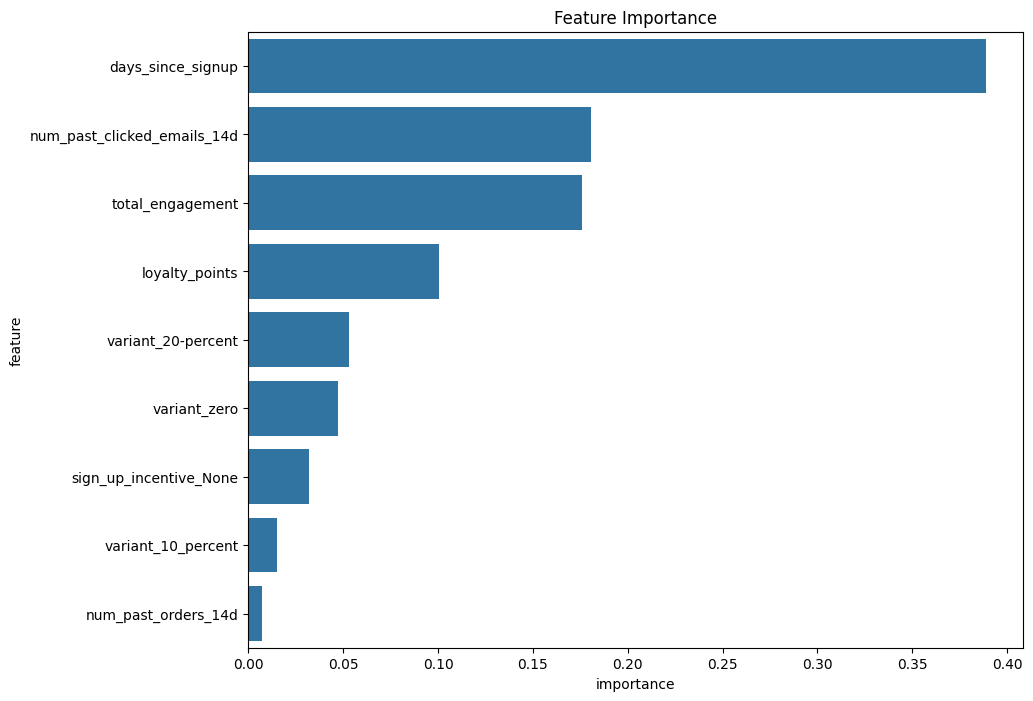

In [ ]:
# # Plot feature importance
# plt.figure(figsize=(10, 8))
# sns.barplot(x='importance', y='feature', data=feature_importance_df)
# plt.title('Feature Importance')
# plt.show()

In [ ]:
# #strategy: Give a coupon to users with high predicted probability of conversion
# df['predicted_conversion_prob'] = model.predict_proba(scaler.transform(X))[:, 1]

# #define different thresholds for giving coupons
# thresholds = [0.2, 0.4, 0.6, 0.8]

# for threshold in thresholds:
#     df[f'give_coupon_threshold_{threshold}'] = df['predicted_conversion_prob'] > threshold

# # Evaluate different strategies
# for threshold in thresholds:
#     conversion_rate = df[df[f'give_coupon_threshold_{threshold}'] == True]['order_conversion'].mean()
#     revenue_per_user = df[df[f'give_coupon_threshold_{threshold}'] == True]['revenue'].mean()
#     print(f"Threshold: {threshold}")
#     print(f"Conversion Rate: {conversion_rate}")
#     print(f"Revenue per User: {revenue_per_user}\n")

Threshold: 0.2
Conversion Rate: 0.09410347366307475
Revenue per User: 0.0

Threshold: 0.4
Conversion Rate: 0.09440860215053763
Revenue per User: 0.0

Threshold: 0.6
Conversion Rate: 0.35444330949948927
Revenue per User: 0.0

Threshold: 0.8
Conversion Rate: 0.7005813953488372
Revenue per User: 0.0



In [ ]:
# #training and target variable
# X = df.drop(['user_id', 'exposed_at', 'order_conversion', 'revenue'], axis=1)
# y = df['order_conversion']

In [ ]:
# #split the data into training and testing sets first
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# #apply SMOTE on the training data
# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# #scale the features using RobustScaler to handle outliers
# scaler = RobustScaler()
# X_train_scaled = scaler.fit_transform(X_train_resampled)
# X_test_scaled = scaler.transform(X_test)


In [ ]:
# #strategy: Predict response to each coupon variant and choose the best one
# def predict_best_coupon(df, model, scaler):
#     variants = ['variant_zero', 'variant_10_percent', 'variant_20-percent']
#     df_features = df.drop(['user_id', 'exposed_at', 'order_conversion', 'revenue'], axis=1)
#     df_features_scaled = scaler.transform(df_features)

#     variant_probabilities = pd.DataFrame(index=df.index)

#     for variant in variants:
#         df_variant = df_features.copy()
#         for col in variants:
#             df_variant[col] = 0
#         df_variant[variant] = 1
#         df_variant_scaled = scaler.transform(df_variant)
#         variant_probabilities[variant] = model.predict_proba(df_variant_scaled)[:, 1]

#     df['best_variant'] = variant_probabilities.idxmax(axis=1)
#     return df

# #apply the strategy
# df = predict_best_coupon(df, best_model, scaler)

# #evaluate the new strategy
# conversion_with_best_coupon = df[df['best_variant'] != 'variant_zero']['order_conversion'].mean()
# conversion_without_coupon = df[df['best_variant'] == 'variant_zero']['order_conversion'].mean()

# print(f"Conversion Rate with Best Coupon: {conversion_with_best_coupon}")
# print(f"Conversion Rate without Coupon: {conversion_without_coupon}")


Conversion Rate with Best Coupon: 0.04610667819661177
Conversion Rate without Coupon: 0.07740230319048517


In [ ]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pickle

# from sklearn.model_selection import train_test_split, RandomizedSearchCV
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# import xgboost as xgb
# from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
# from sklearn.preprocessing import StandardScaler, RobustScaler
# from imblearn.over_sampling import SMOTE, ADASYN
# from sklearn.utils.class_weight import compute_class_weight


In [ ]:
# #assuming df is the dataframe created from SQL queries in Step 1

# #create additional features
# df['total_engagement'] = df['num_past_orders_14d'] + df['num_past_clicked_emails_14d']
# df['days_since_last_engagement'] = df['days_since_signup'] - df[['num_past_orders_14d', 'num_past_clicked_emails_14d']].max(axis=1)
# df['loyalty_points_per_day'] = df['loyalty_points'] / (df['days_since_signup'] + 1)  # Adding 1 to avoid division by zero

# #convert variant_name to numerical
# df = pd.get_dummies(df, columns=['variant', 'sign_up_incentive'], drop_first=True)

# #create a column for the 10% off variant
# df['variant_10_percent'] = 1 - (df['variant_20-percent'] + df['variant_zero'])

# #training and target variable
# X = df.drop(['user_id', 'exposed_at', 'order_conversion', 'revenue'], axis=1)
# y = df['order_conversion']

# #split the data into training and testing sets first
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# #address class imbalance using SMOTE and ADASYN
# smote = SMOTE(random_state=42)
# adasyn = ADASYN(random_state=42)

# X_train_resampled_smote, y_train_resampled_smote = smote.fit_resample(X_train, y_train)
# X_train_resampled_adasyn, y_train_resampled_adasyn = adasyn.fit_resample(X_train, y_train)

# #scale the features using RobustScaler to handle outliers
# scaler = RobustScaler()
# X_train_scaled_smote = scaler.fit_transform(X_train_resampled_smote)
# X_train_scaled_adasyn = scaler.fit_transform(X_train_resampled_adasyn)
# X_test_scaled = scaler.transform(X_test)


In [ ]:
# #hyperparameter tuning for Random Forest
# rf_param_dist = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'bootstrap': [True, False]
# }

# rf_random_search = RandomizedSearchCV(
#     estimator=RandomForestClassifier(random_state=42, class_weight='balanced'),
#     param_distributions=rf_param_dist,
#     n_iter=50,
#     scoring='roc_auc',
#     cv=3,
#     verbose=2,
#     random_state=42,
#     n_jobs=-1
# )

# rf_random_search.fit(X_train_scaled_smote, y_train_resampled_smote)
# best_rf = rf_random_search.best_estimator_


Fitting 3 folds for each of 50 candidates, totalling 150 fits


In [ ]:
# #initialize models
# models = {
#     "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=200),
#     "Random Forest": best_rf,
#     "Gradient Boosting": GradientBoostingClassifier(random_state=42),
#     "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, scale_pos_weight=len(y_train) / sum(y_train))
# }

# #function to train and evaluate models
# def train_and_evaluate(models, X_train, y_train, X_test, y_test):
#     results = []

#     for model_name, model in models.items():
#         model.fit(X_train, y_train)
#         y_pred = model.predict(X_test)
#         y_pred_prob = model.predict_proba(X_test)[:, 1]

#         accuracy = accuracy_score(y_test, y_pred)
#         precision = precision_score(y_test, y_pred)
#         recall = recall_score(y_test, y_pred)
#         f1 = f1_score(y_test, y_pred)
#         roc_auc = roc_auc_score(y_test, y_pred_prob)

#         results.append({
#             "Model": model_name,
#             "Accuracy": accuracy,
#             "Precision": precision,
#             "Recall": recall,
#             "F1 Score": f1,
#             "ROC AUC": roc_auc
#         })

#     results_df = pd.DataFrame(results)
#     return results_df

# #evaluate models with SMOTE resampled data
# results_smote = train_and_evaluate(models, X_train_scaled_smote, y_train_resampled_smote, X_test_scaled, y_test)
# print("Results with SMOTE:")
# print(results_smote)

# #evaluate models with ADASYN resampled data
# results_adasyn = train_and_evaluate(models, X_train_scaled_adasyn, y_train_resampled_adasyn, X_test_scaled, y_test)
# print("Results with ADASYN:")
# print(results_adasyn)



Results with SMOTE:
                 Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
0  Logistic Regression  0.650943   0.065558  0.435331  0.113955  0.563020
1        Random Forest  0.731132   0.059947  0.287066  0.099183  0.532446
2    Gradient Boosting  0.663468   0.047988  0.293375  0.082483  0.526818
3              XGBoost  0.323357   0.051575  0.697161  0.096045  0.503192
Results with ADASYN:
                 Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
0  Logistic Regression  0.652733   0.066317  0.438486  0.115209  0.561252
1        Random Forest  0.873292   0.069030  0.116719  0.086753  0.517993
2    Gradient Boosting  0.892323   0.074074  0.094637  0.083102  0.525476
3              XGBoost  0.335394   0.050560  0.668770  0.094013  0.485389


In [ ]:
# #train the final model
# best_model = best_rf
# best_model.fit(X_train_scaled_smote, y_train_resampled_smote)

# #function to evaluate the best model
# def evaluate_best_model(model, X_test, y_test):
#     y_pred = model.predict(X_test)
#     y_pred_prob = model.predict_proba(X_test)[:, 1]

#     accuracy = accuracy_score(y_test, y_pred)
#     precision = precision_score(y_test, y_pred)
#     recall = recall_score(y_test, y_pred)
#     f1 = f1_score(y_test, y_pred)
#     roc_auc = roc_auc_score(y_test, y_pred_prob)

#     print("Best Model Evaluation:")
#     print(f"Accuracy: {accuracy:.4f}")
#     print(f"Precision: {precision:.4f}")
#     print(f"Recall: {recall:.4f}")
#     print(f"F1 Score: {f1:.4f}")
#     print(f"ROC AUC: {roc_auc:.4f}")
#     print("\nClassification Report:")
#     print(classification_report(y_test, y_pred))

# #evaluate the retrained model on the test set
# evaluate_best_model(best_model, X_test_scaled, y_test)

# #calculate baseline metrics
# baseline_conversion_rate = df[df['variant_10_percent'] == 1]['order_conversion'].mean()
# baseline_revenue_per_user = df[df['variant_10_percent'] == 1]['revenue'].mean()

# print(f"Baseline Conversion Rate: {baseline_conversion_rate}")
# print(f"Baseline Revenue per User: {baseline_revenue_per_user}")



Best Model Evaluation:
Accuracy: 0.7311
Precision: 0.0599
Recall: 0.2871
F1 Score: 0.0992
ROC AUC: 0.5324

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.76      0.84      5831
           1       0.06      0.29      0.10       317

    accuracy                           0.73      6148
   macro avg       0.51      0.52      0.47      6148
weighted avg       0.91      0.73      0.80      6148

Baseline Conversion Rate: 0.04918829590745601
Baseline Revenue per User: 0.0


In [ ]:
# #define different constraints on the number of coupons
# def apply_coupon_constraints(df, model, scaler, coupon_percentage):
#     df_features = df.drop(['user_id', 'exposed_at', 'order_conversion', 'revenue'], axis=1)
#     df_features_scaled = scaler.transform(df_features)

#     df['predicted_prob'] = model.predict_proba(df_features_scaled)[:, 1]
#     df = df.sort_values('predicted_prob', ascending=False)

#     coupon_threshold = int(len(df) * coupon_percentage)
#     df['coupon_given'] = 0
#     df.iloc[:coupon_threshold, df.columns.get_loc('coupon_given')] = 1

#     return df

# #scenarios with different coupon percentages
# coupon_scenarios = [0.1, 0.25, 0.5]  # 10%, 25%, 50% of users get a coupon

# for scenario in coupon_scenarios:
#     df_scenario = apply_coupon_constraints(df.copy(), best_model, scaler, scenario)
#     conversion_rate = df_scenario[df_scenario['coupon_given'] == 1]['order_conversion'].mean()
#     print(f"Coupon Percentage: {scenario*100}%")
#     print(f"Conversion Rate: {conversion_rate}\n")

# #summary of improvements
# print(f"Baseline Conversion Rate: {baseline_conversion_rate}")
# print(f"Model Conversion Rate: {model_conversion_rate}")
# print(f"Conversion Rate with Best Coupon: {conversion_with_best_coupon}")
# print(f"Conversion Rate without Coupon: {conversion_without_coupon}")


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- best_variant
